# Marketing Campaign Analysis

This notebook performs exploratory data analysis and hypothesis testing on marketing campaign data to understand customer acquisition factors.

# Step 0: Load and Investigate the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

In [2]:
#if running Colab to connect to GDrive
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Filepath on GDrive
# filepath = '/content/drive/MyDrive/School/SimpliLearn/PC DS-Applied Data Science with Python/End Projects/working/marketing_data.csv'

# Filepath on local machine
filepath = "./data/marketing_data.csv"

In [4]:
# Reading the data
df = pd.read_csv(filepath)

In [5]:
# Investigate the data

In [6]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', ' Income ',
       'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain', 'Country'],
      dtype='object')

In [7]:
# Fix the Income column name to remove the spaces
df.rename(columns={' Income ': 'Income'}, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4   Income               2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

# Step 1: Examine Dt_Customer and Income

In [9]:
# Step 1: Examine Dt_Customer and Income
print("Initial Data Examination:")
print("\nDt_Customer data type:", df['Dt_Customer'].dtype)
print("Income data type:", df['Income'].dtype)
print("\nMissing values:")
print(df[['Dt_Customer', 'Income']].isnull().sum())

Initial Data Examination:

Dt_Customer data type: object
Income data type: object

Missing values:
Dt_Customer     0
Income         24
dtype: int64


In [10]:
df[df['Income'].isnull()].head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
134,8996,1957,PhD,Married,NaN,2,1,11/19/12,4,230,...,8,9,0,0,0,0,0,0,0,GER
262,1994,1983,Graduation,Married,NaN,1,0,11/15/13,11,5,...,2,7,0,0,0,0,0,0,0,US
394,3769,1972,PhD,Together,NaN,1,0,3/2/14,17,25,...,3,7,0,0,0,0,0,0,0,AUS
449,5255,1986,Graduation,Single,NaN,1,0,2/20/13,19,5,...,0,1,0,0,0,0,0,0,0,AUS
525,8268,1961,PhD,Married,NaN,0,1,7/11/13,23,352,...,7,6,0,0,0,0,0,0,0,CA


In [11]:
# Cleaning Income column
df['Income'] = df['Income'].str.replace('$', '').str.replace(',', '').str.strip()
df['Income'] = pd.to_numeric(df['Income'], errors='coerce')
df['Income'].dtype

dtype('float64')

In [12]:
# Information after cleaning the Income column
print("Number of NaN values for Income column:",df['Income'].isna().sum())

print("Basic Statistical Data for Income column:")
print(df['Income'].describe())
# Missing values will be imputed later

Number of NaN values for Income column: 24
Basic Statistical Data for Income column:
count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64


In [13]:
# Converting Dt_Customer to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%m/%d/%y')

In [14]:
print(df['Dt_Customer'].head(10))
df['Dt_Customer'].dtype

0   2014-06-16
1   2014-06-15
2   2014-05-13
3   2014-05-11
4   2014-04-08
5   2014-03-17
6   2014-01-29
7   2014-01-18
8   2014-01-11
9   2014-01-11
Name: Dt_Customer, dtype: datetime64[ns]


dtype('<M8[ns]')

In [15]:
# Clean Education column
print("Original Education values:",df['Education'].value_counts(dropna=False))

Original Education values: Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64


In [16]:
# Data Cleaning for Education
# The instructions emphasize cleaning the Education categories.
# The presence of 2n Cycle alongside Master suggests potential redundancy, as both likely refer
# to postgraduate education. Basic is vague and may need clarification or standardization.

# Here’s how cleansing the Education values was undertaken:
# Merge 2n Cycle with Master: Since 2n Cycle corresponds to a Master’s degree in the Bologna Process,
# combining it with Master standardizes the category to a more universally recognized term.
# Clarify Basic: Without additional context, Basic likely represents education below a Bachelor’s degree
# (e.g., high school or less). It will be renamed to something clearer: "Secondary"
# Retain Graduation and rename to Bachelor

df['Education'] = df['Education'].replace('2n Cycle', 'Master')
df['Education'] = df['Education'].replace('Graduation', 'Bachelor')
df['Education'] = df['Education'].replace('Basic', 'Secondary')

print("Cleaned Education values:",df['Education'].value_counts(dropna=False))

Cleaned Education values: Education
Bachelor     1127
Master        573
PhD           486
Secondary      54
Name: count, dtype: int64


In [17]:
# Clean Marital_Status column
print("Original Marital Status values:",df['Marital_Status'].value_counts(dropna=False))

Original Marital Status values: Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
YOLO          2
Absurd        2
Name: count, dtype: int64


In [18]:
# The cleaning process used for merging non-standard categories in the Marital Status column
# Merge (YOLO, Alone, Absurd) into a standard one (Single), reducing redundancy:
# - YOLO (2 entries): Likely a joke or informal entry implying a single. Merging into Single.
# - Alone (3 entries): Implies no partner, aligning with Single. Merging into Single.
# - Absurd (2 entries): Ambiguous, but with such low frequency, it’s likely an error or non-standard
# Retain Married, Together, Divorced, and Widow as distinct categories, as they reflect standard marital statuses.
# - Married: 864 (standard, refers to legally married individuals)
# - Together: 580 (likely refers to cohabiting partners, not legally married)
# - Divorced: 232 (standard, refers to legally divorced individuals)
# - Widow: 77 (standard, refers to individuals whose spouse has passed away)

df['Marital_Status'] = df['Marital_Status'].replace(['YOLO', 'Alone', 'Absurd'], 'Single')
print("\nCleaned Marital_Status values:",df['Marital_Status'].value_counts(dropna=False))


Cleaned Marital_Status values: Marital_Status
Married     864
Together    580
Single      487
Divorced    232
Widow        77
Name: count, dtype: int64


In [19]:
# Calculate mean and median income by Marital Status and Education
# Pivot tables for visualization
mean_pivot = df.pivot_table(values='Income', index='Marital_Status', columns='Education',
                           aggfunc='mean').round(2)
median_pivot = df.pivot_table(values='Income', index='Marital_Status', columns='Education',
                             aggfunc='median').round(2)

print("\nMean Income Pivot Table:")
print(mean_pivot)
print("\nMedian Income Pivot Table:")
print(median_pivot)


Mean Income Pivot Table:
Education       Bachelor    Master       PhD  Secondary
Marital_Status                                         
Divorced        54526.04  49972.83  53096.62    9548.00
Married         50800.26  50686.06  58138.03   21960.50
Single          51365.63  53751.08  53039.67   18238.67
Together        55758.48  49495.94  56041.42   21240.07
Widow           54976.66  56211.12  60288.08   22123.00

Median Income Pivot Table:
Education       Bachelor   Master      PhD  Secondary
Marital_Status                                       
Divorced         55635.0  49297.0  50613.5     9548.0
Married          50737.0  50017.0  57081.5    22352.0
Single           49973.5  49514.0  48918.0    16383.0
Together         53977.0  47586.5  56756.0    23179.0
Widow            58275.0  51459.5  57032.0    22123.0


# Step 2: Missing Value Imputation

In [20]:
skewness = df["Income"].skew()
print(f"\nSkewness of Income distribution: {round(skewness, 2)}")
# The skewness value of 6.76 indicates extremely high positive skewness in income distribution
# - Mean income will be substantially higher than median income
# - Standard deviation may not accurately represent typical variation
# - The bulk of data points cluster at lower income levels
# - Use median instead of mean as a measure of central tendency


Skewness of Income distribution: 6.76


In [21]:
# Impute missing Income values using the median income for the appropriate Education and Maritial_Status categories
income_median = df.groupby(['Education', 'Marital_Status'])['Income'].median()
def impute_income(row):
    if pd.isna(row['Income']):
        try:
            return income_median[row['Education'], row['Marital_Status']]
        except KeyError:
            return df['Income'].median()  # Fallback to overall mean if combination is missing
    return row['Income']
df['Income'] = df.apply(impute_income, axis=1)

In [22]:
# Stats update post Input column update
print("Missing values:",df['Income'].isna().sum())
print("Basic Statistical Data for Income column after imputation:")
print(df['Income'].describe().round(2))
# Notice the count value has increased from 2216 to 2240 which has also altered the overall mean and median

Missing values: 0
Basic Statistical Data for Income column after imputation:
count      2240.00
mean      52229.62
std       25040.06
min        1730.00
25%       35538.75
50%       51222.50
75%       68289.75
max      666666.00
Name: Income, dtype: float64


In [23]:
median_pivot = df.pivot_table(values='Income', index='Marital_Status', columns='Education',
                             aggfunc='median').round(2)

print("\nMedian Income Pivot Table:")
print(median_pivot)
# The categorical median has been retained as seen in the updated pivot table


Median Income Pivot Table:
Education       Bachelor   Master      PhD  Secondary
Marital_Status                                       
Divorced         55635.0  49297.0  50613.5     9548.0
Married          50737.0  50017.0  57081.5    22352.0
Single           49973.5  49514.0  48918.0    16383.0
Together         53977.0  47586.5  56756.0    23179.0
Widow            58275.0  51459.5  57032.0    22123.0


# Step 3: Feature Engineering

In [24]:
# Feature Engineering
current_year = 2025
df['Age'] = current_year - df['Year_Birth']
df['Total_Children'] = df['Kidhome'] + df['Teenhome']
df['Total_Spending'] = df[['MntWines', 'MntFruits', 'MntMeatProducts',
                          'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
df['Total_Purchases'] = df[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

# Step 4: Visualizations - Box Plots, Histograms, and Density Plots

In [25]:
# Save current settings and plot reset
original_rcParams = rcParams.copy()

def reset_plot_settings():
    """Reset both matplotlib and seaborn to clean defaults"""
    plt.close('all')  # Close existing figures
    plt.rcdefaults()  # Reset matplotlib
    sns.reset_defaults()  # Reset seaborn

# Use between sections:
reset_plot_settings()

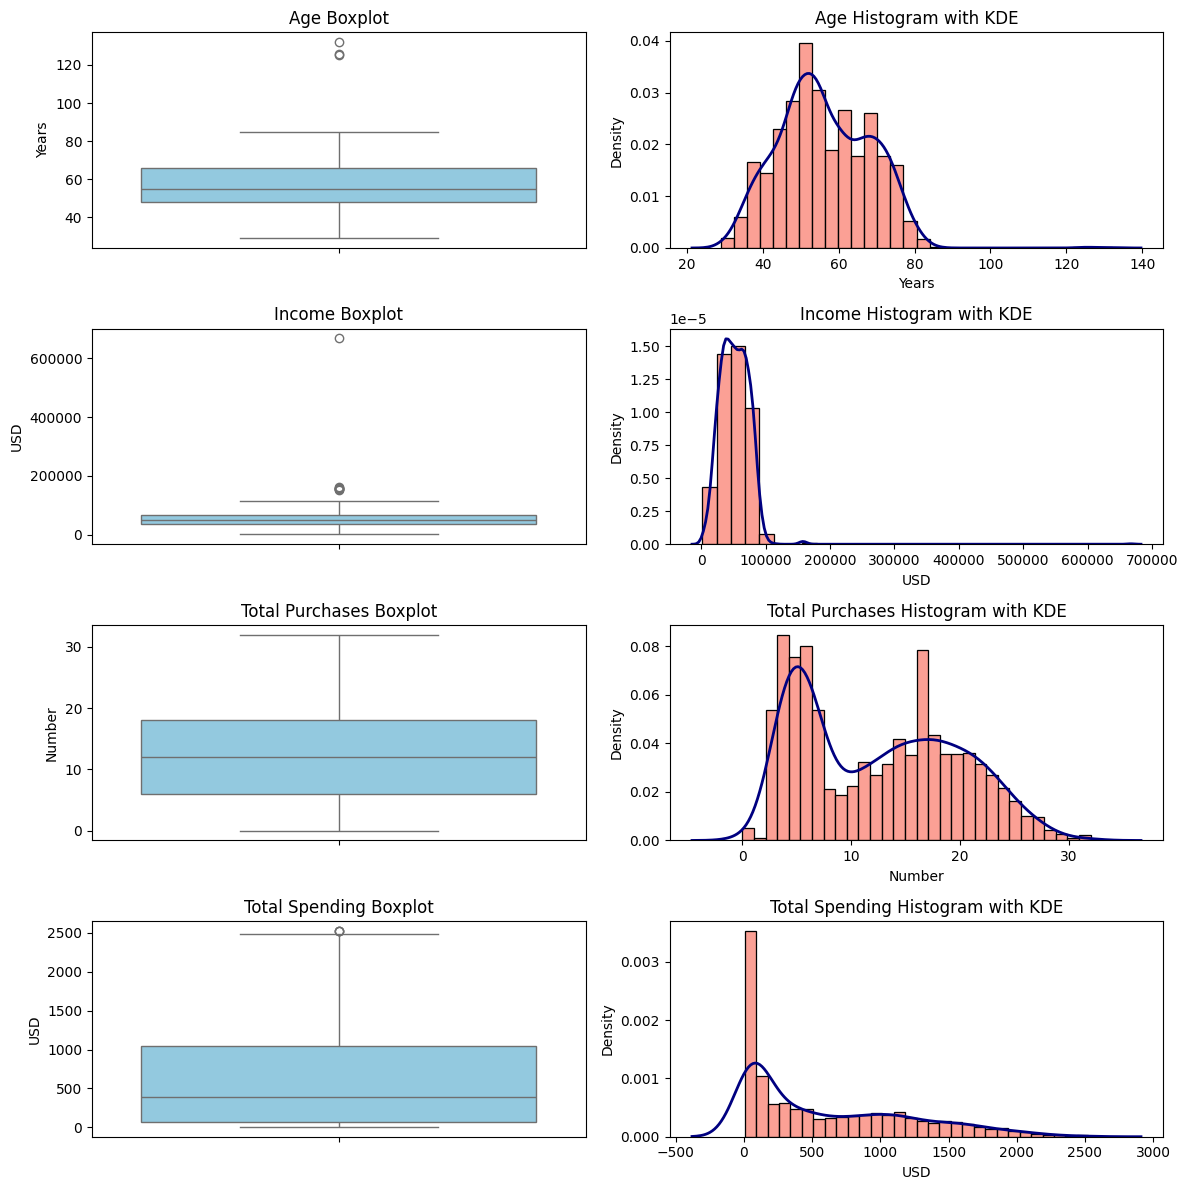

In [26]:
# Step 4: Visualizations - Box Plots, Histograms, and Density Plots

variables = ["Age", "Income", "Total_Purchases", "Total_Spending"]
titles = ["Age", "Income", "Total Purchases", "Total Spending"]
units = ["Years", "USD", "Number", "USD"]

# Create a 4x3 subplot grid
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))

for i, var in enumerate(variables):
    # Boxplot
    sns.boxplot(y=df[var], ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f"{titles[i]} Boxplot")
    axes[i, 0].set_ylabel(units[i])

    # Histogram with KDE overlay
    sns.histplot(data=df, x=var, ax=axes[i, 1], bins=30, color="salmon", stat="density")
    sns.kdeplot(data=df, x=var, ax=axes[i, 1], color="navy", linewidth=2)
    axes[i, 1].set_title(f"{titles[i]} Histogram with KDE")
    axes[i, 1].set_xlabel(units[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [27]:
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f'Lower Bound: {lower_bound}')
    df_lower = df[df[column] < lower_bound]
    if df_lower[column].count() > 0:
        print(f'Number of records below Lower Bound: {df_lower[column].count()}')
        print(df_lower[column])
    else:
        print(f'Number of records below Lower Bound: {df_lower[column].count()}')

    print(f'Upper Bound: {upper_bound}')
    df_upper = df[df[column] > upper_bound]
    if df_upper[column].count() > 0:
        print(f'Number of records above Upper Bound: {df_upper[column].count()}')
        print(df_upper[column])
    else:
        print(f'Number of records above Upper Bound: {df_upper[column].count()}')

    #print(df[(df[column] >= lower_bound) & (df[column] <= upper_bound)][column].count())

variables = ['Age','Income','Total_Purchases','Total_Spending']
for var in variables:
    print(f'\n{var}')
    find_outliers(df, var)

# Results from the plots and outlier calculations show that for the variables Total_Purchases and Total_Spending
# It does not make sense to remove any outliers. While the data is skewed the outlier data is relevant.

# For the variables Age and Income different results are shown.
# - For Age the 3 outlier values seem to be erroneous since the ages are above 93.
#   The suggestion is to remove these rows.
# - For Income 1 of the 8 values seems to be erroneous or at least drastically different than the rest
#   of the data.
#   The suggestion is to remove the rows with Income outliers above the upper bound


Age
Lower Bound: 21.0
Number of records below Lower Bound: 0
Upper Bound: 93.0
Number of records above Upper Bound: 3
513     132
827     126
2233    125
Name: Age, dtype: int64

Income
Lower Bound: -13587.75
Number of records below Lower Bound: 0
Upper Bound: 117416.25
Number of records above Upper Bound: 8
325     157146.0
497     160803.0
527     666666.0
731     162397.0
853     157733.0
1826    153924.0
1925    156924.0
2204    157243.0
Name: Income, dtype: float64

Total_Purchases
Lower Bound: -12.0
Number of records below Lower Bound: 0
Upper Bound: 36.0
Number of records above Upper Bound: 0

Total_Spending
Lower Bound: -1396.375
Number of records below Lower Bound: 0
Upper Bound: 2510.625
Number of records above Upper Bound: 3
671     2525
672     2525
1404    2524
Name: Total_Spending, dtype: int64


In [28]:
# Remove the outliers for Age and Income

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

variables = ['Age','Income']
for var in variables:
    df = remove_outliers(df, var)

In [29]:
# Final Check to see if there are any negative values for age, income, total purchases, or total spending
variables = ["Age", "Income", "Total_Purchases", "Total_Spending"]
for var in variables:
    print(df[df[var] < 0][var].count())
# No negative values found

0
0
0
0


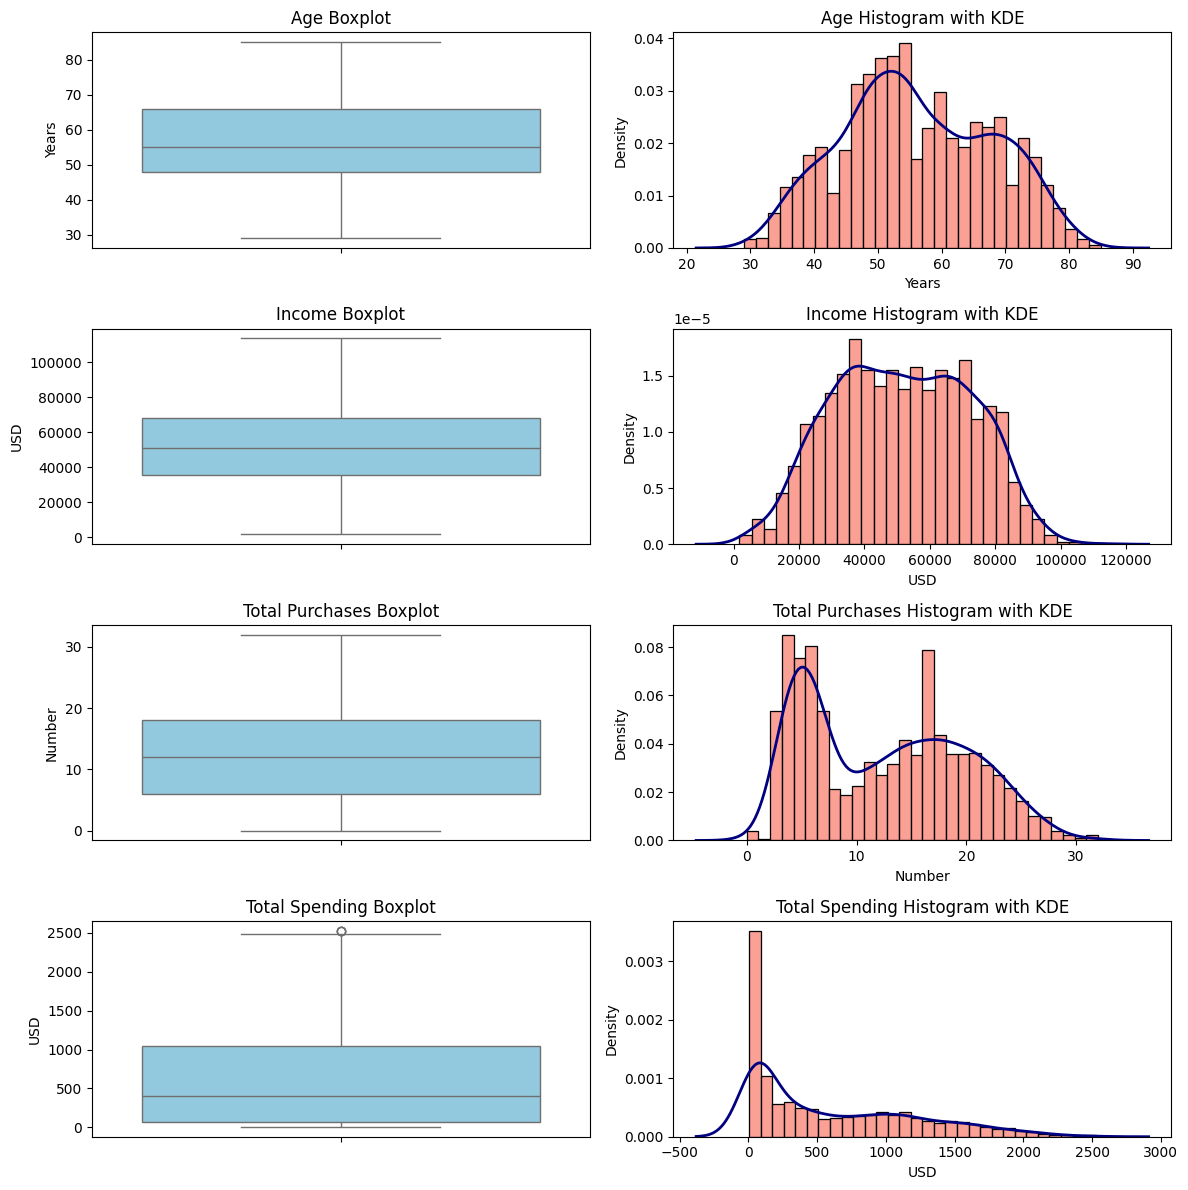

In [30]:
# Visualizations - Box Plots, Histograms, and Density Plots post removal of outlier values

reset_plot_settings()

variables = ['Age','Income','Total_Purchases','Total_Spending']
titles = ['Age','Income','Total Purchases','Total Spending']
units = ['Years','USD','Number','USD']

# Create a 4x3 subplot grid
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,12))

for i, var in enumerate(variables):
    # Boxplot
    sns.boxplot(y=df[var], ax=axes[i,0], color='skyblue')
    axes[i,0].set_title(f'{titles[i]} Boxplot')
    axes[i,0].set_ylabel(units[i])

    # Histogram with KDE overlay
    sns.histplot(data=df, x=var, ax=axes[i,1], bins=30, color='salmon', stat='density')
    sns.kdeplot(data=df, x=var, ax=axes[i,1], color='navy', linewidth=2)
    axes[i,1].set_title(f'{titles[i]} Histogram with KDE')
    axes[i,1].set_xlabel(units[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# After removing outliers from Age and Income the box and histogram plots look
# more like a normal curve. However Total Purchases and Total Spending are still
# very heavilty right skewed.

In [31]:
median_pivot = df.pivot_table(
    values="Income", index="Marital_Status", columns="Education", aggfunc="median"
).round(2)

print("\nMedian Income Pivot Table:")
print(median_pivot)
# The categorical median has been retained after removing the outliers except for the Divorced-Bachelors category where it has gone from 55635.00 to 55599.00 as seen in the updated pivot table.


Median Income Pivot Table:
Education       Bachelor   Master      PhD  Secondary
Marital_Status                                       
Divorced         55599.0  49476.0  50613.5     9548.0
Married          50737.0  50017.0  57072.0    22352.0
Single           49973.5  49514.0  48918.0    16383.0
Together         53977.0  47586.5  56575.0    23179.0
Widow            58275.0  51459.5  57032.0    22123.0


# Step 5: Encoding Categorical Variables

In [32]:
# Encoding Categorical Variables
# Ordinal encoding for Education
#print(df['Education'].value_counts())
education_mapping = {'Secondary': 1, 'Bachelor': 2, 'Master': 3, 'PhD': 4}
df['Education_Encoded'] = df['Education'].map(education_mapping)
df.drop(columns=['Education'],inplace=True)
#print(df['Education_Encoded'].value_counts())

# One-hot encoding for Marital_Status and Country
df = pd.get_dummies(df, columns=['Marital_Status', 'Country'], prefix=['Marital', 'Country'])

In [33]:
df.columns # df columns post encoding

Index(['ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Response', 'Complain', 'Age', 'Total_Children', 'Total_Spending',
       'Total_Purchases', 'Education_Encoded', 'Marital_Divorced',
       'Marital_Married', 'Marital_Single', 'Marital_Together',
       'Marital_Widow', 'Country_AUS', 'Country_CA', 'Country_GER',
       'Country_IND', 'Country_ME', 'Country_SA', 'Country_SP', 'Country_US'],
      dtype='object')

# Step 6: Correlation Heatmap

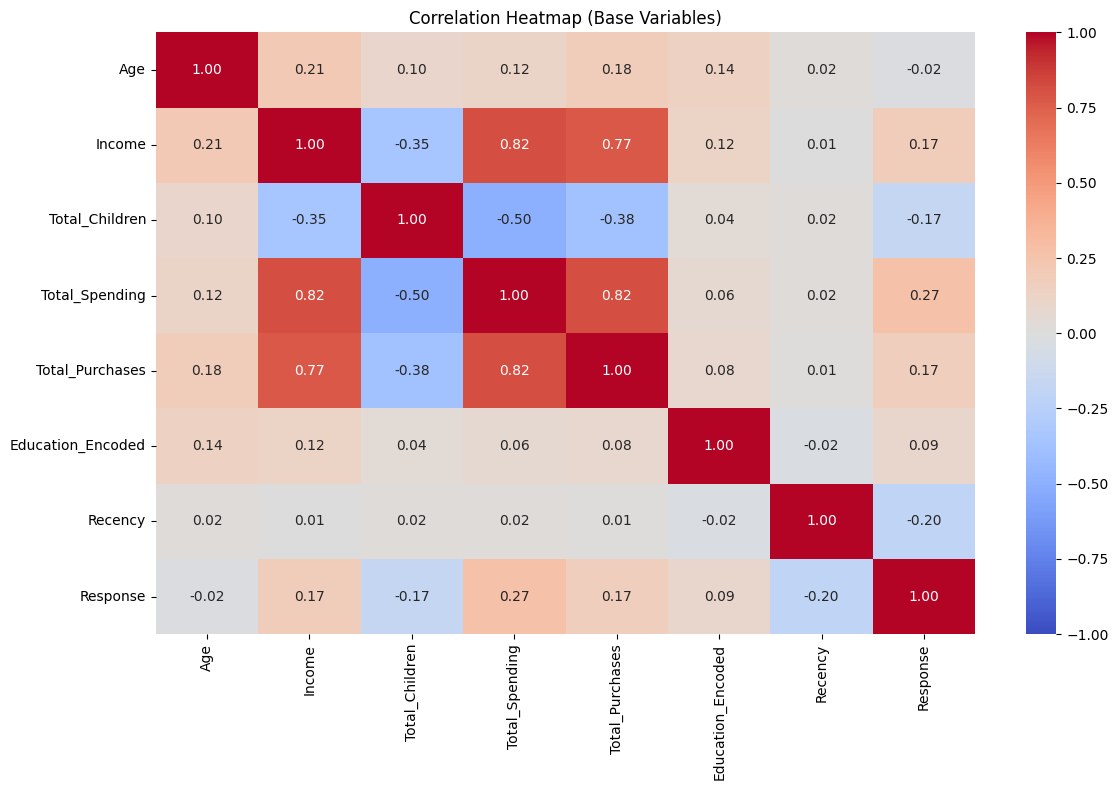

In [34]:
# Base Correlation Heatmap
reset_plot_settings()

plt.figure(figsize=(12, 8))
correlation_matrix = df[
    [
        "Age",
        "Income",
        "Total_Children",
        "Total_Spending",
        "Total_Purchases",
        "Education_Encoded",
        "Recency",
        "Response",
    ]
].corr()
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    fmt=".2f",
)
plt.title("Correlation Heatmap (Base Variables)")
plt.tight_layout()
plt.show()

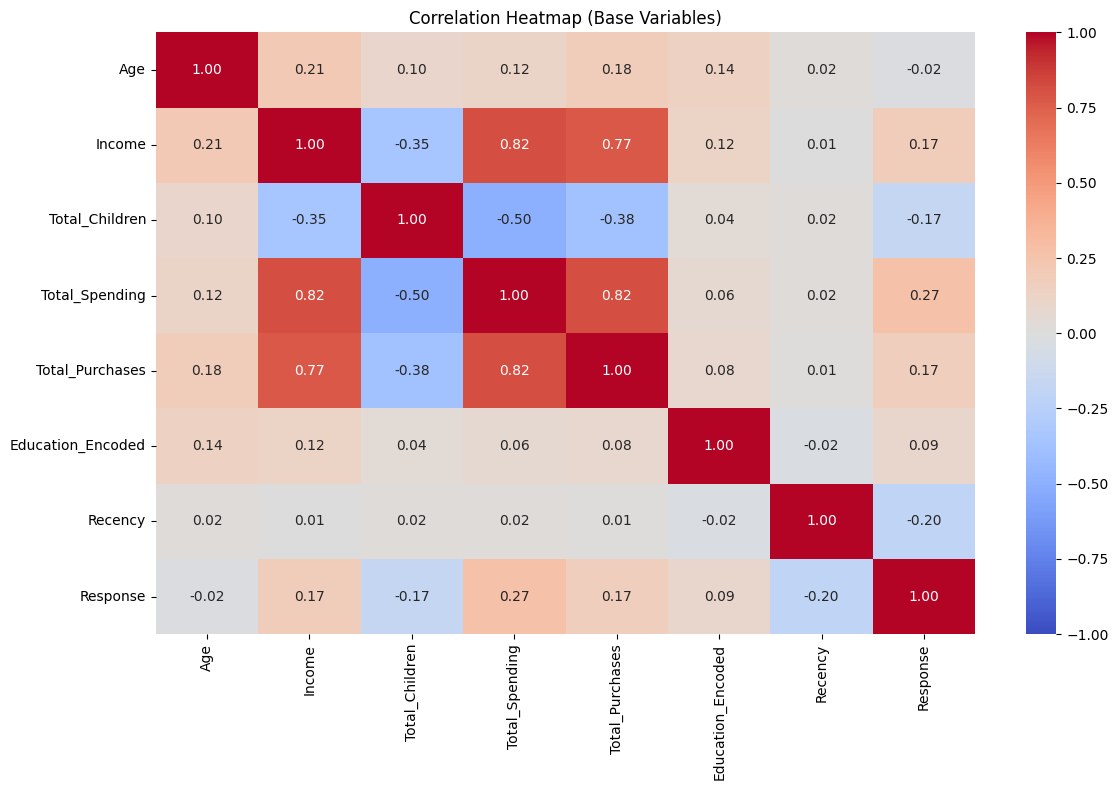

In [35]:
# Correlation Heatmap (Base Plus Products, Recency and Last Campaign Response)
reset_plot_settings()

plt.figure(figsize=(12, 8))
correlation_matrix = df[
    [
        "Age",
        "Income",
        "Total_Children",
        "Total_Spending",
        "Total_Purchases",
        "Education_Encoded",
        "Recency",
        "Response",
    ]
].corr()
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    fmt=".2f",
)
plt.title("Correlation Heatmap (Base Variables)")
plt.tight_layout()
plt.show()

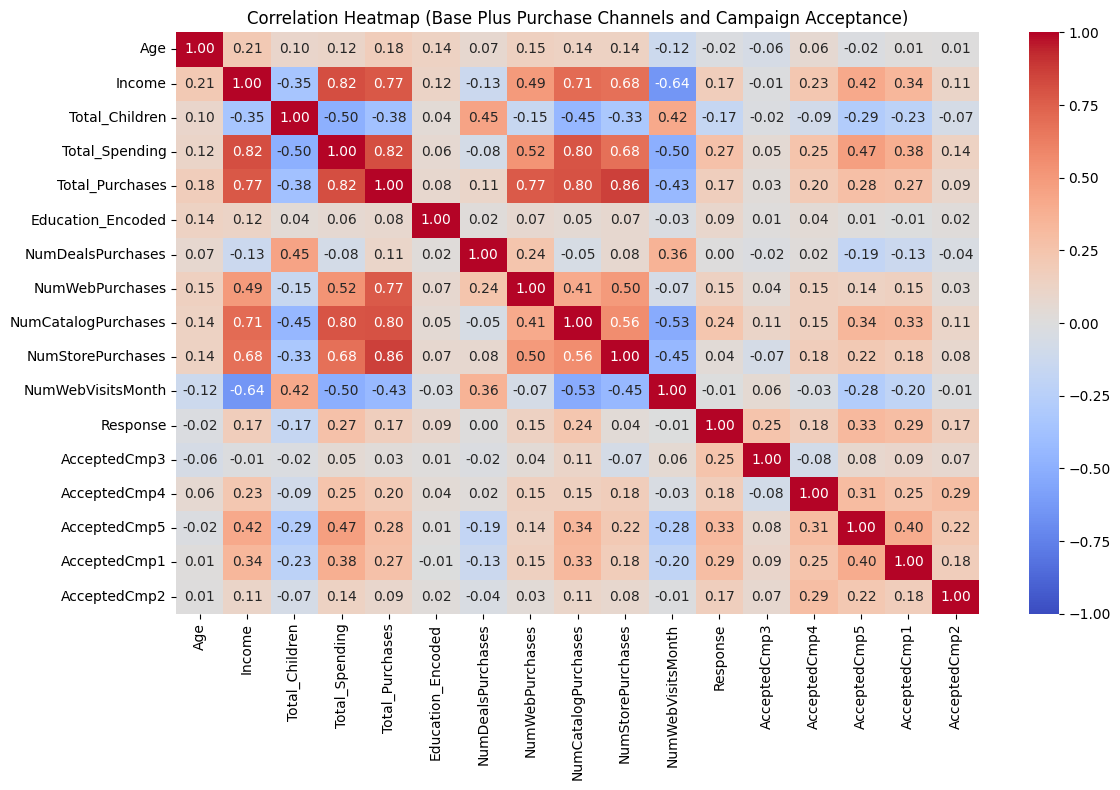

In [36]:
# Correlation Heatmap (Base Plus Purchase Channels and Campaign Acceptance)
reset_plot_settings()

plt.figure(figsize=(12, 8))
correlation_matrix = df[
    [
        "Age",
        "Income",
        "Total_Children",
        "Total_Spending",
        "Total_Purchases",
        "Education_Encoded",
        "NumDealsPurchases",
        "NumWebPurchases",
        "NumCatalogPurchases",
        "NumStorePurchases",
        "NumWebVisitsMonth",
        "Response",
        "AcceptedCmp3",
        "AcceptedCmp4",
        "AcceptedCmp5",
        "AcceptedCmp1",
        "AcceptedCmp2",
    ]
].corr()
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    fmt=".2f",
)
plt.title("Correlation Heatmap (Base Plus Purchase Channels and Campaign Acceptance)")
plt.tight_layout()
plt.show()


# Step 7: Hypothesis Testing

## Older individuals prefer in-store shopping

In [37]:
# a. Older individuals prefer in-store shopping

# Specify H₀ and H₁:
# H₀: The distributions of NumStorePurchases for older and younger customers are
#     identical (no difference in distribution).
# H₁: The distributions of NumStorePurchases for older customers is stochastically
#     greater (they tend to have higher values).

# Normality and Test Choice:
# •  Use the t-test if NumStorePurchases is approximately normally distributed.
# •  Use the Mann-Whitney U test if the data is non-normal.

# Interpreting Results:
# •  P-value ≤ α (0.05): Reject H₀, concluding there is evidence that older customers have
#    higher in-store purchases.
# •  P-value > α: Fail to reject H₀, indicating insufficient evidence that older customers
#    prefer in-store purchases.

In [38]:
# Split data
older = df[df['Age'] >= df['Age'].median()]['NumStorePurchases']
younger = df[df['Age'] < df['Age'].median()]['NumStorePurchases']
df['Older'] = df['Age'] >= df['Age'].median()

In [39]:
# Normality check
from scipy.stats import shapiro

# Purpose:
# •  Tests the null hypothesis (H₀) that the data from the groups is normally distributed.
# •  Alternative hypothesis (H₁): The data is not normally distributed.

for group, data in [(1, older), (0, younger)]:
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk Test for Older Individuals = {group}: p-value = {p:.4f}")
    if p < 0.05:
        print("  p-value < 0.05: Reject H₀, data is not normally distributed.")
    else:
        print("  p-value >= 0.05: Fail to reject H₀, data may be normally distributed.")

Shapiro-Wilk Test for Older Individuals = 1: p-value = 0.0000
  p-value < 0.05: Reject H₀, data is not normally distributed.
Shapiro-Wilk Test for Older Individuals = 0: p-value = 0.0000
  p-value < 0.05: Reject H₀, data is not normally distributed.


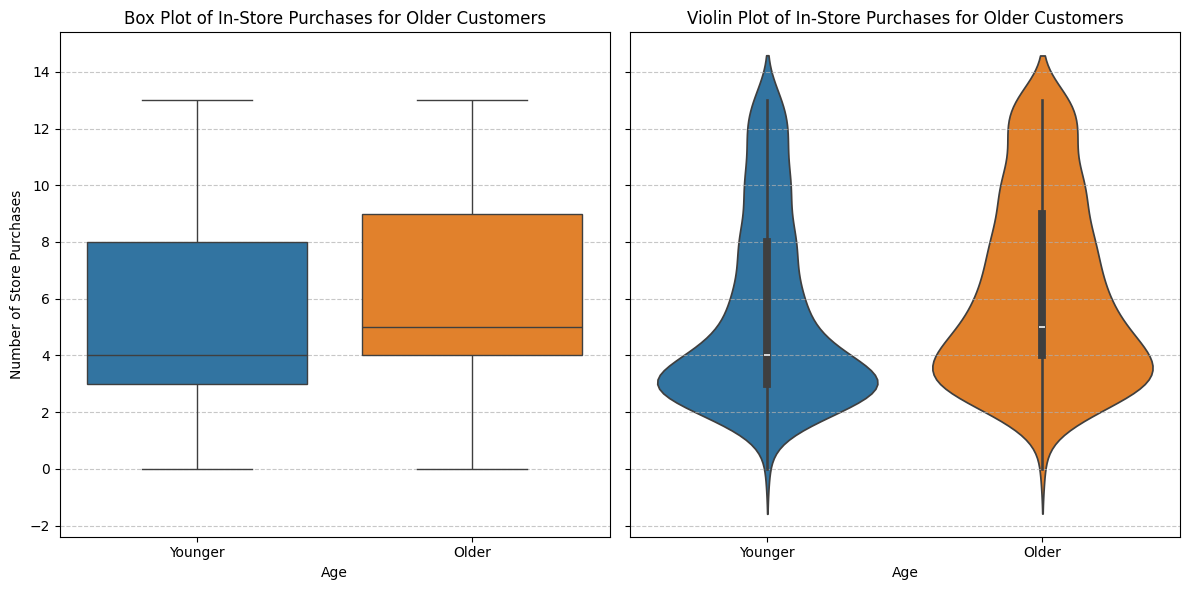


Descriptive Statistics
           mean  median       std  count
Older                                   
False  5.359259     4.0  3.200239   1080
True   6.238468     5.0  3.224830   1149


In [40]:
# Create a figure with two subplots side by side
reset_plot_settings()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Boxplot
sns.boxplot(
    x="Older", y="NumStorePurchases", data=df, ax=ax1, hue="Older", legend=False
)
ax1.set_title("Box Plot of In-Store Purchases for Older Customers")
ax1.set_xlabel("Age")
ax1.set_xticks([0, 1], ["Younger", "Older"])
ax1.set_ylabel("Number of Store Purchases")
# ax1.set_ylim(-2,28)
ax1.grid(True, axis="y", linestyle="--", alpha=0.7)

# Violin Plot
sns.violinplot(
    x="Older", data=df, y="NumStorePurchases", legend=False, ax=ax2, hue="Older"
)
ax2.set_title("Violin Plot of In-Store Purchases for Older Customers")
ax2.set_xlabel("Age")
ax2.set_xticks([0, 1], ["Younger", "Older"])
ax2.grid(True, axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# Descriptive Statistics
current_stats = df.groupby("Older")["NumStorePurchases"].agg(["mean", "median", "std", "count"])
print("\nDescriptive Statistics")
print(current_stats)

# Shapiro-Wilk test and plots show data is not normally distributed so a non-parametric
# test seems more appropriate

In [41]:
# Perform Mann-Whitney U Test (One-Tailed)

# H₀: The distributions of NumStorePurchases for older and younger customers are
#     identical (no difference in distribution).
# H₁: The distributions of NumStorePurchases for older is stochastically
#     greater (they tend to have higher values).
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(older, younger, alternative='greater')
print(f'Mann-Whitney U Test: statistic = {stat:.4f}, p-value = {p_value:.4f}')

# Interpretation
alpha = 0.05
if p_value <= alpha:
    print('Reject H₀: Older customer have higher in-store puchases')
else:
    print('Fail to reject H₀: No evidence that older customers have higher in-store purchases')

Mann-Whitney U Test: statistic = 735103.5000, p-value = 0.0000
Reject H₀: Older customer have higher in-store puchases


In [42]:
# Why a t-test may be ok
# Large sample sizes (e.g., n > 30 or ideally n > 50 per group), due to the Central Limit Theorem (CLT).
# The CLT states that the sampling distribution of the mean approaches normality as sample size increases,
# even if the underlying data is non-normal.

print(f"Sample size for Older Customers:\n{df['Older'].value_counts()}")
# Sample Size is Large: Both groups (Older = 1 and 0) have n > 50
# the CLT helps ensure the t-test is robust.

Sample size for Older Customers:
Older
True     1149
False    1080
Name: count, dtype: int64


In [43]:
# Perform Levene's test

# Purpose:
# •  Tests the null hypothesis (H₀) that the variances of the groups are equal.
# •  Alternative hypothesis (H₁): The variances are not equal.

# Variations of test:
# •  Standard Levene’s Test: Uses the group mean for calculating deviations.
# •  Modified Levene’s Test (Brown-Forsythe): Uses the group median instead of the mean,
#    which is more robust to non-normal data.

# Implications of test:
# •  If Levene’s test indicates unequal variances (p-value ≤ 0.05), use Welch’s t-test to compare means.
# •  If variances are equal, use the standard t-test.

from scipy.stats import levene
alpha = 0.05

stat, p_levene = levene(older, younger, center='median')  # Use 'median' for Brown-Forsythe
print(f"Levene's Test: statistic = {stat:.4f}, p-value = {p_value:.4f}")

print(f"{'Unequal variances' if p_levene < alpha else 'Equal variances'} (p {'<' if p_levene < alpha else '>='} {alpha})")

Levene's Test: statistic = 4.1209, p-value = 0.0000
Unequal variances (p < 0.05)


In [44]:
# Unequal variances use Welch’s t-test to compare means
# Run parametric Welch's t-test

from scipy.stats import ttest_ind
print("\nWelch's t-Test (unequal variances):")
stat, p_welch = ttest_ind(older, younger, alternative='greater', equal_var=False)
print(f"Welch's t-test: statistic = {stat:.4f}, p-value = {p_welch:.4f}")

if p_welch <= alpha:
    print('Reject H₀: Older customers have higher in-store puchases')
else:
    print('Fail to reject H₀: No evidence that older customers have higher in-store purchases')


Welch's t-Test (unequal variances):
Welch's t-test: statistic = 6.4582, p-value = 0.0000
Reject H₀: Older customers have higher in-store puchases


In [45]:
# Conclusion
# Both the parametric test (Welch's t-Test) and the non-parametric test (Mann-Whitney U Test)
# reject H₀, meaning there is evidence that older customers have more in-store purchases

## Customers with children prefer online shopping

In [46]:
# b. Customers with children prefer online shopping

# Specify H₀ and H₁:
# H₀: The distributions of NumWebPurchases for customers with and without children are
#     identical (no difference in distribution).
# H₁: The distribution of NumWebPurchases for customers with children is stochastically
#     greater (they tend to have higher values).

# Normality and Test Choice:
# •  Use the t-test if NumWebPurchases is approximately normally distributed.
# •  Use the Mann-Whitney U test if the data is non-normal.

# Interpreting Results:
# •  P-value ≤ α (0.05): Reject H₀, concluding there is evidence that customers with children
#    prefer online shopping.
# •  P-value > α: Fail to reject H₀, indicating insufficient evidence that customers with children
#    prefer online shopping.

In [47]:
# Split data
df['Has_Children'] = df['Total_Children'] >= 1
web_with_children = df[df['Has_Children'] == 1]['NumWebPurchases']
web_without_children = df[df['Has_Children'] == 0]['NumWebPurchases']

In [48]:
# Normality check
from scipy.stats import shapiro

# Purpose:
# •  Tests the null hypothesis (H₀) that the data from the groups is normally distributed.
# •  Alternative hypothesis (H₁): The data is not normally distributed.

for group, data in [(1, web_with_children), (0, web_without_children)]:
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk Test for Has_Children = {group}: p-value = {p:.4f}")
    if p < 0.05:
        print("  p-value < 0.05: Reject H₀, data is not normally distributed.")
    else:
        print("  p-value >= 0.05: Fail to reject H₀, data may be normally distributed.")

Shapiro-Wilk Test for Has_Children = 1: p-value = 0.0000
  p-value < 0.05: Reject H₀, data is not normally distributed.
Shapiro-Wilk Test for Has_Children = 0: p-value = 0.0000
  p-value < 0.05: Reject H₀, data is not normally distributed.


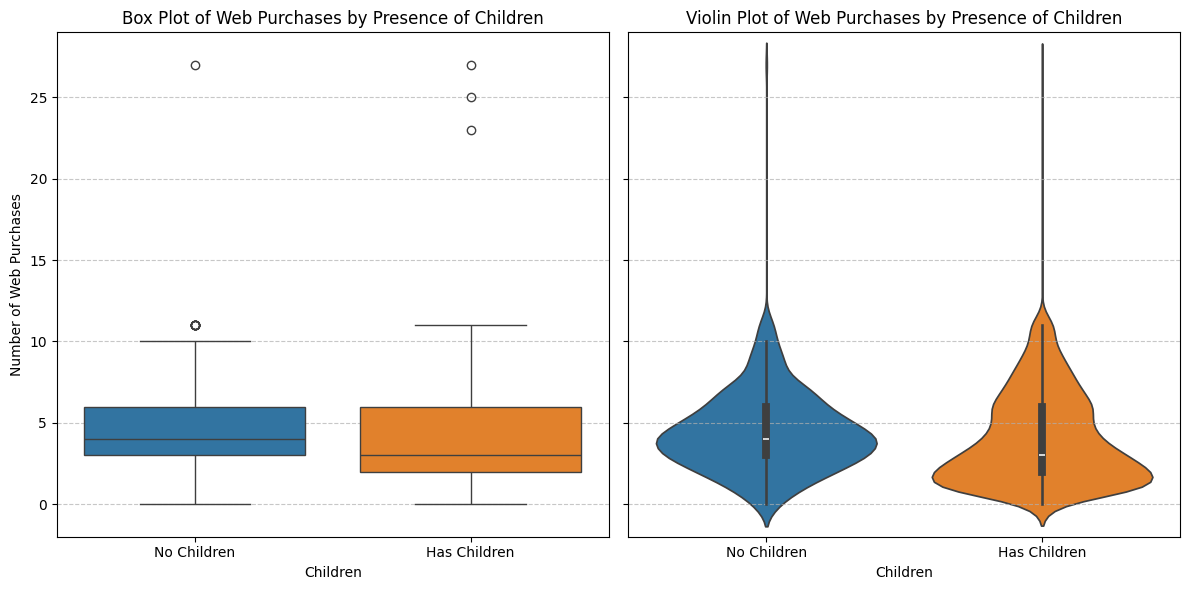


Descriptive Statistics
                  mean  median       std  count
Has_Children                                   
False         4.421801     4.0  2.468273    633
True          3.972431     3.0  2.879044   1596


In [49]:
# Create a figure with two subplots side by side

reset_plot_settings()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Boxplot
sns.boxplot(
    x="Has_Children",
    y="NumWebPurchases",
    data=df,
    ax=ax1,
    hue="Has_Children",
    legend=False,
)
ax1.set_title("Box Plot of Web Purchases by Presence of Children")
ax1.set_ylabel("Number of Web Purchases")
ax1.set_xlabel("Children")
ax1.set_xticks([0, 1], ["No Children", "Has Children"])
ax1.set_ylim(-2, 29)
ax1.grid(True, axis="y", linestyle="--", alpha=0.7)

# Violin Plot
sns.violinplot(
    x="Has_Children",
    data=df,
    y="NumWebPurchases",
    legend=False,
    ax=ax2,
    hue="Has_Children",
)
ax2.set_title("Violin Plot of Web Purchases by Presence of Children")
ax2.set_xlabel("Children")
ax2.set_xticks([0, 1], ["No Children", "Has Children"])
ax2.grid(True, axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# Descriptive Statistics
print("\nDescriptive Statistics")
dfstats = df.groupby("Has_Children")["NumWebPurchases"].agg(
    ["mean", "median", "std", "count"]
)
print(dfstats)

# Shapiro-Wilk test and plots show data is not normally distributed so a non-parametric
# test seems more appropriate

In [50]:
# Perform Mann-Whitney U Test (One-Tailed)
# H₀: The distributions of NumWebPurchases for customers with and without children are
#     identical (no difference in distribution).
# H₁: The distribution of NumWebPurchases for customers with children is greater
#     (they tend to have higher values).
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(web_with_children, web_without_children, alternative='greater')
print(f'Mann-Whitney U Test: statistic = {stat:.4f}, p-value = {p_value:.4f}')

# Interpretation
alpha = 0.05
if p_value <= alpha:
    print('Reject H₀: Customers with children have higher web puchases puchases')
else:
    print('Fail to reject H₀: No evidence that customers with children have higher web purchases')

Mann-Whitney U Test: statistic = 428511.0000, p-value = 1.0000
Fail to reject H₀: No evidence that customers with children have higher web purchases


In [51]:
# Why a t-test may be ok
# Large sample sizes (e.g., n > 30 or ideally n > 50 per group), due to the Central Limit Theorem (CLT).
# The CLT states that the sampling distribution of the mean approaches normality as sample size increases,
# even if the underlying data is non-normal.

print(f"Sample size for Has_Children:\n{df['Has_Children'].value_counts()}")
# Sample Size is Large: Both groups (HasChildren = 1 and 0) have n > 50
# the CLT helps ensure the t-test is robust.

Sample size for Has_Children:
Has_Children
True     1596
False     633
Name: count, dtype: int64


In [52]:
# Perform Levene's test

# Purpose:
# •  Tests the null hypothesis (H₀) that the variances of the groups are equal.
# •  Alternative hypothesis (H₁): The variances are not equal.

# Variations of test:
# •  Standard Levene’s Test: Uses the group mean for calculating deviations.
# •  Modified Levene’s Test (Brown-Forsythe): Uses the group median instead of the mean,
#    which is more robust to non-normal data.

# Implications of test:
# •  If Levene’s test indicates unequal variances (p-value ≤ 0.05), use Welch’s t-test to compare means.
# •  If variances are equal, use the standard t-test.

from scipy.stats import levene
alpha = 0.05

stat, p_levene = levene(web_with_children, web_without_children, center='median')
print(f"\nLevene's Test: statistic = {stat:.4f}, p-value = {p_levene:.4f}")
print(f"{'Unequal variances' if p_levene < alpha else 'Equal variances'} (p {'<' if p_levene < alpha else '>='} {alpha})")


Levene's Test: statistic = 22.7688, p-value = 0.0000
Unequal variances (p < 0.05)


In [53]:
# Unequal variances use Welch’s t-test to compare means
# Run parametric Welch's t-test

from scipy.stats import ttest_ind
print("\nWelch's t-Test (unequal variances):")
stat, p_welch = ttest_ind(web_with_children, web_without_children, alternative='greater', equal_var=False)
print(f"Welch's t-test: statistic = {stat:.4f}, p-value = {p_welch:.4f}")

if p_welch <= alpha:
    print('Reject H₀: Customers with children have higher web puchases puchases')
else:
    print('Fail to reject H₀: No evidence that customers with children have higher web purchases')


Welch's t-Test (unequal variances):
Welch's t-test: statistic = -3.6915, p-value = 0.9999
Fail to reject H₀: No evidence that customers with children have higher web purchases


In [54]:
# Conclusion
# Both the parametric test (Welch's t-Test) and the non-parametric test (Mann-Whitney U Test)
# fail to reject H₀, meaning there is no evidence that customers with children have higher web purchases

## c. Store Sales Cannibalization by alternative distribution channels

In [55]:
# c. Store sales cannibalization

# Specify H₀ and H₁:
# H₀: The distributions of In-Store Purchases versus all the other Purchase Methods are
#     identical (no difference in distribution).
# H₁: The distribution of In-Store Purchass versus the other Purchase Methods is
#     stochastically less (In-store purchase tends to be less than other purchase methods).

# Normality and Test Choice:
# •  Use the t-test if the data from the 3 purchase groups is approximately normally distributed.
# •  Use the Mann-Whitney U test if the data is non-normal.

#### Correlation Test Choices
# Pearson:
# •  Assumes linear relationships
# •  Sensitive to outliers and skewness
# •  Underestimates relationships in your data
# Spearman:
# •  Works with monotonic relationships
# •  Robust to outliers
# •  Better captures the true strength of relationships in your skewed data

In [56]:
# Extract relevant columns
store_purchases = df['NumStorePurchases']
catalog_purchases = df['NumCatalogPurchases']
web_purchases = df['NumWebPurchases']
total_purchases = df['Total_Purchases']
alternate_purchases = df['NumWebPurchases'] + df['NumCatalogPurchases']

In [57]:
cols = ["NumStorePurchases", "NumWebPurchases", "NumCatalogPurchases", "Total_Purchases"]
df_cann = df[cols].dropna().reset_index(drop=True)

In [58]:
# Descriptive Statistics
print("Descriptive Statistics:")
print(round(df_cann.describe(),2))

Descriptive Statistics:
       NumStorePurchases  NumWebPurchases  NumCatalogPurchases  \
count            2229.00          2229.00              2229.00   
mean                5.81             4.10                 2.64   
std                 3.24             2.78                 2.80   
min                 0.00             0.00                 0.00   
25%                 3.00             2.00                 0.00   
50%                 5.00             4.00                 2.00   
75%                 8.00             6.00                 4.00   
max                13.00            27.00                28.00   

       Total_Purchases  
count          2229.00  
mean             12.55  
std               7.18  
min               0.00  
25%               6.00  
50%              12.00  
75%              18.00  
max              32.00  


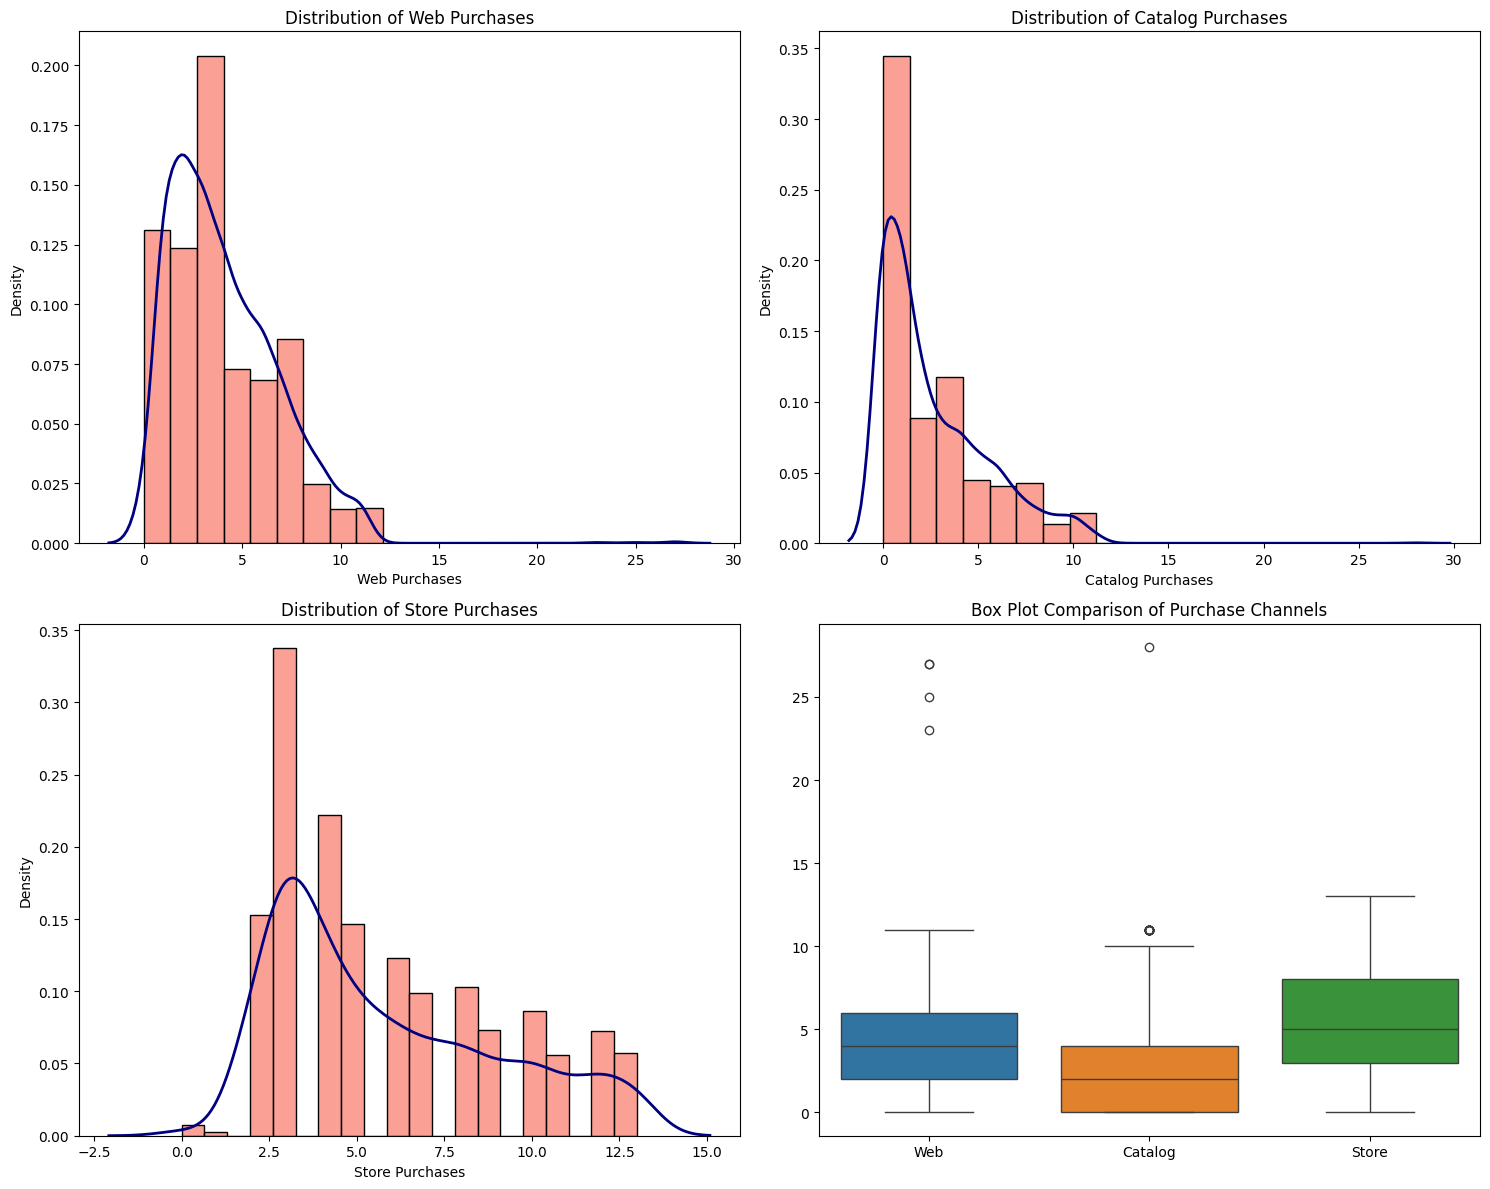

Summary Statistics by Channel:
                      count      mean       std  min  25%  50%  75%   max
NumWebPurchases      2229.0  4.100045  2.775461  0.0  2.0  4.0  6.0  27.0
NumCatalogPurchases  2229.0  2.636608  2.796161  0.0  0.0  2.0  4.0  28.0
NumStorePurchases    2229.0  5.812472  3.242144  0.0  3.0  5.0  8.0  13.0


In [59]:
# Create subplots for distribution analysis
reset_plot_settings()
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution of each purchase channel
channels = ["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"]
channel_labels = ["Web Purchases", "Catalog Purchases", "Store Purchases"]

for i, (channel, label) in enumerate(zip(channels, channel_labels)):
    row = i // 2
    col = i % 2

    # Histogram with KDE overlay
    sns.histplot(
        data=df,
        x=channel,
        kde=False,
        ax=axes[row, col],
        bins=20,
        color="salmon",
        stat="density",
    )
    sns.kdeplot(data=df, x=channel, ax=axes[row, col], color="navy", linewidth=2)
    axes[row, col].set_title(f"Distribution of {label}")
    axes[row, col].set_xlabel(label)

# Box plot comparison
sns.boxplot(data=df[channels], ax=axes[1, 1])
axes[1, 1].set_title("Box Plot Comparison of Purchase Channels")
axes[1, 1].set_xticklabels(["Web", "Catalog", "Store"])

plt.tight_layout()
plt.show()

# Summary statistics
print("Summary Statistics by Channel:")
summary_stats = df[channels].describe().T
print(summary_stats)

# Results
# Purchase data is highly right skewed. Suggests that non-parametric hypothesis testing should be used


Detailed Correlation Analysis:

NumWebPurchases vs NumCatalogPurchases:
   Pearson r=0.411, p=0.0000
   Spearman r=0.624, p=0.0000


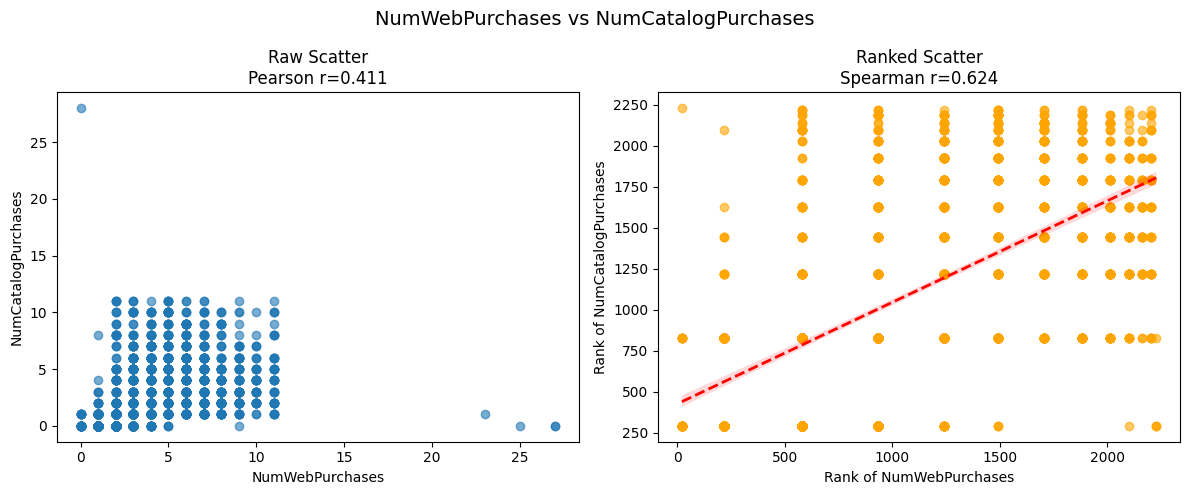


NumWebPurchases vs NumStorePurchases:
   Pearson r=0.499, p=0.0000
   Spearman r=0.669, p=0.0000


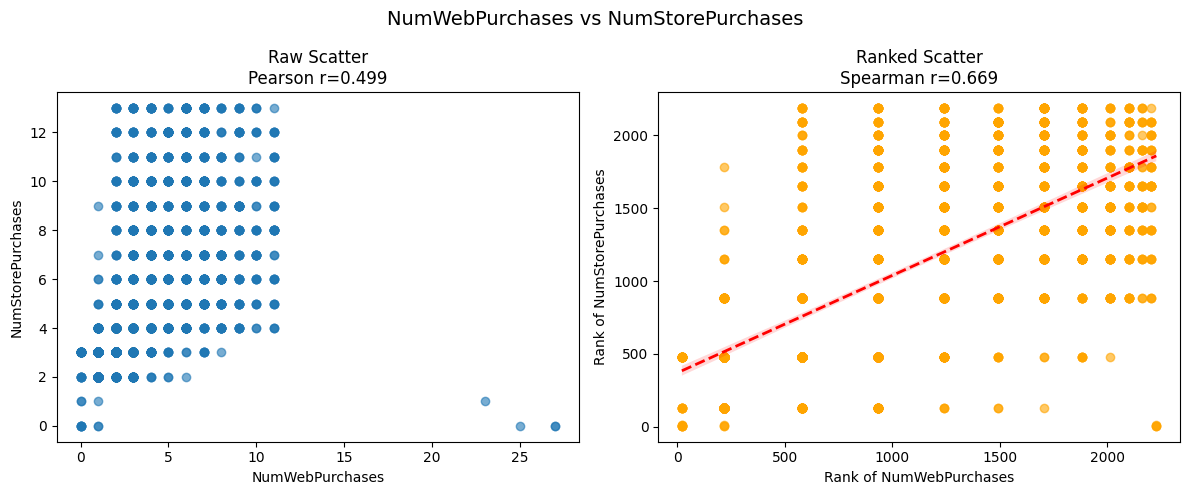


NumCatalogPurchases vs NumStorePurchases:
   Pearson r=0.562, p=0.0000
   Spearman r=0.715, p=0.0000


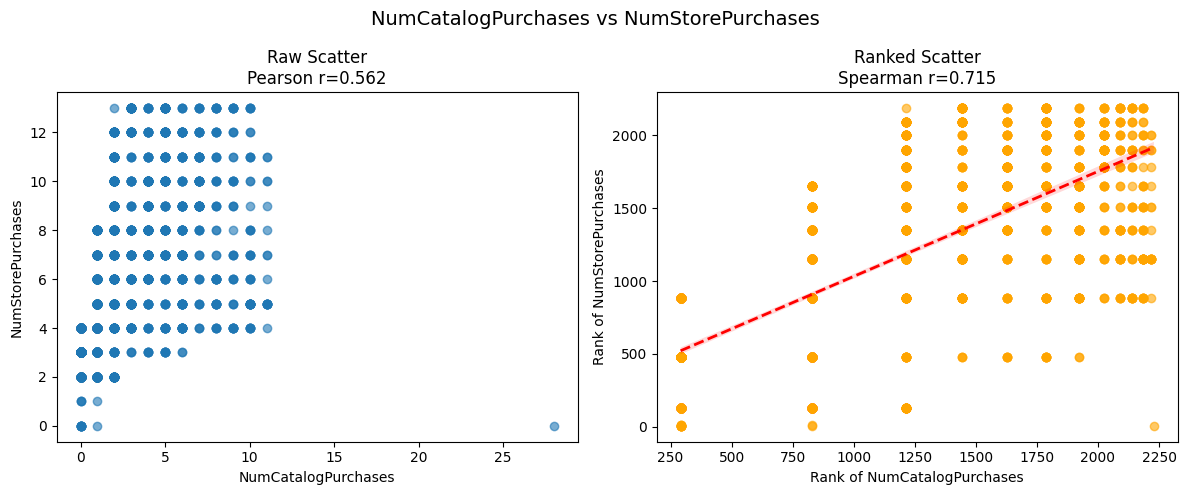

In [60]:
# Correlation matrix for purchase channels
reset_plot_settings()

# Calculate correlation matrix
corr_matrix = df[channels].corr(method="spearman")

# Create a new dataframe for the analysis
df_corr = df.copy()
# Create a new channel which is the sum of non-store purchases
df_corr["AlternativeChannelPurchases"] = (
    df_corr["NumWebPurchases"] + df_corr["NumCatalogPurchases"]
)

# Print correlation coefficients with p-values
channels = ["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"]
print("\nDetailed Correlation Analysis:")


for i in range(len(channels)):
    for j in range(i + 1, len(channels)):
        x = df_corr[channels[i]]
        y = df_corr[channels[j]]

        # Pearson correlation
        p_corr, p_value = pearsonr(x, y)

        # Spearman correlation
        s_corr, s_value = spearmanr(x, y)

        print(f"\n{channels[i]} vs {channels[j]}:")
        print(f"   Pearson r={p_corr:.3f}, p={p_value:.4f}")
        print(f"   Spearman r={s_corr:.3f}, p={s_value:.4f}")

        # ---- PLOTS ----
        reset_plot_settings()
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Scatter plot (raw)
        axes[0].scatter(x, y, alpha=0.6)
        axes[0].set_xlabel(channels[i])
        axes[0].set_ylabel(channels[j])
        axes[0].set_title(f"Raw Scatter\nPearson r={p_corr:.3f}")

        # Scatter plot (ranked)
        rank_x = x.rank()
        rank_y = y.rank()
        sns.regplot(
            x=rank_x,
            y=rank_y,
            ax=axes[1],
            scatter_kws={"alpha": 0.6},
            color="orange",
            line_kws={"color": "red", "linestyle": "--", "linewidth": 2},
        )
        # axes[1].scatter(rank_x, rank_y, alpha=0.6, color="orange")
        axes[1].set_xlabel(f"Rank of {channels[i]}")
        axes[1].set_ylabel(f"Rank of {channels[j]}")
        axes[1].set_title(f"Ranked Scatter\nSpearman r={s_corr:.3f}")

        plt.suptitle(f"{channels[i]} vs {channels[j]}", fontsize=14)
        plt.tight_layout()
        plt.show()

In [61]:
# Spearman vs Pearson:
# Spearman is better for this analysis for several reasons:
# 1. Consistently Higher Values: Spearman correlations are substantially higher across all comparisons (0.62-0.72 vs 0.41-0.56),
#    suggesting the relationships are stronger than Pearson indicates.
# 2. Non-linear Relationships: The raw scatter plots show clear evidence of non-linearity - clustered, stepped patterns rather
#    than smooth linear trends. This is particularly evident in the catalog vs store plot.
# 3. Outliers and Skewness: The scatter plots reveal outliers and skewed distributions that can suppress Pearson
#    correlations but don’t affect Spearman.
# 4. Count Data Characteristics: Purchase counts often follow non-normal distributions making rank-based correlation
#    more appropriate.
# The ranked scatter plots on the right show much cleaner, more linear relationships, confirming that Spearman better
# captures the true strength of association between these purchase behaviors.

# Use Spearman correlation for customer behavior analysis, as it provides a more accurate picture of the monotonic
# relationships between different purchase channels.​​​​​​​​​​​​​​​​

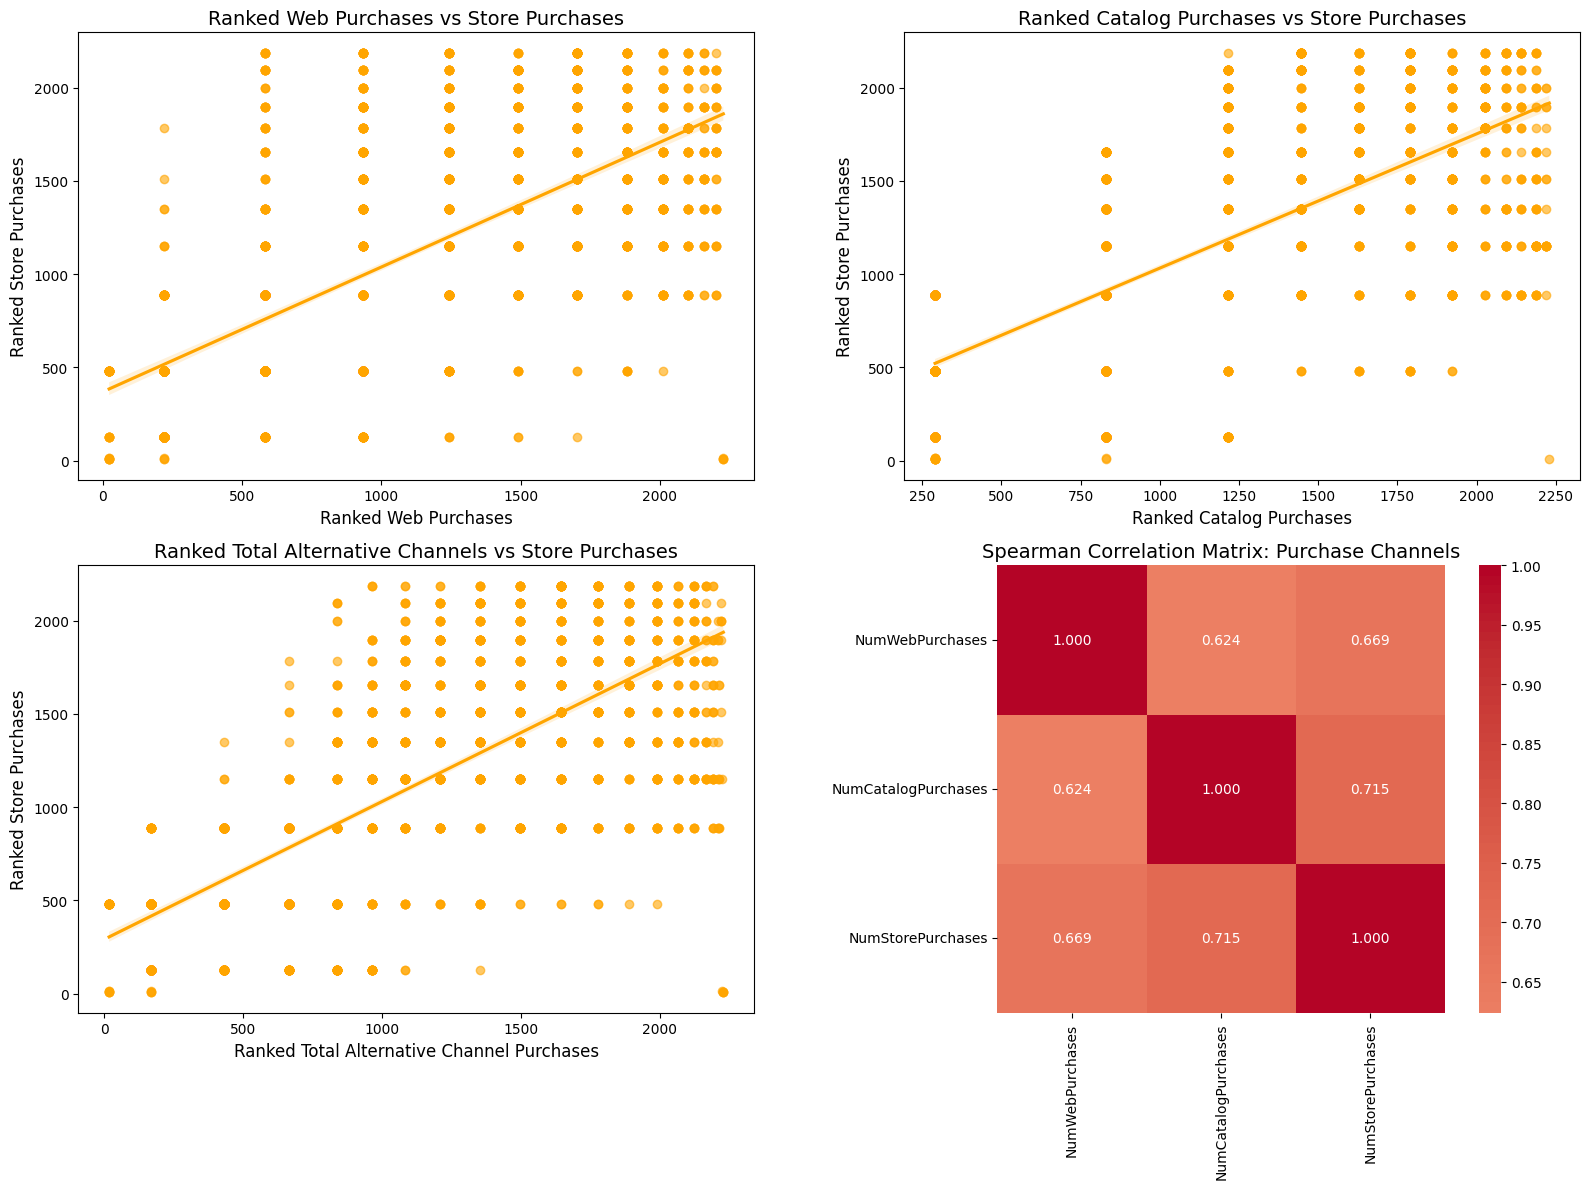

In [62]:
# Create comprehensive scatter plot analysis
reset_plot_settings()
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

df_corr["RankedWebPurchases"] = df_corr["NumWebPurchases"].rank()
df_corr["RankedCatalogPurchases"] = df_corr["NumCatalogPurchases"].rank()
df_corr["RankedStorePurchases"] = df_corr["NumStorePurchases"].rank()
df_corr["RankedAlternativeChannelPurchases"] = df_corr[
    "AlternativeChannelPurchases"
].rank()

# Web vs Store
sns.regplot(
    data=df_corr,
    x="RankedWebPurchases",
    y="RankedStorePurchases",
    ax=axes[0, 0],
    scatter_kws={"alpha": 0.6},
    color="orange",
)
axes[0, 0].set_title("Ranked Web Purchases vs Store Purchases", fontsize=14)
axes[0, 0].set_xlabel("Ranked Web Purchases", fontsize=12)
axes[0, 0].set_ylabel("Ranked Store Purchases", fontsize=12)

# Catalog vs Store
sns.regplot(
    data=df_corr,
    x="RankedCatalogPurchases",
    y="RankedStorePurchases",
    ax=axes[0, 1],
    scatter_kws={"alpha": 0.6},
    color="orange",
)
axes[0, 1].set_title("Ranked Catalog Purchases vs Store Purchases", fontsize=14)
axes[0, 1].set_xlabel("Ranked Catalog Purchases", fontsize=12)
axes[0, 1].set_ylabel("Ranked Store Purchases", fontsize=12)

# Alternative Combined vs Store
sns.regplot(
    data=df_corr,
    x="RankedAlternativeChannelPurchases",
    y="RankedStorePurchases",
    ax=axes[1, 0],
    scatter_kws={"alpha": 0.6},
    color="orange",
)
axes[1, 0].set_title(
    "Ranked Total Alternative Channels vs Store Purchases", fontsize=14
)
axes[1, 0].set_xlabel("Ranked Total Alternative Channel Purchases", fontsize=12)
axes[1, 0].set_ylabel("Ranked Store Purchases", fontsize=12)

# Create heatmap with Spearman Correlation results
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    square=True,
    ax=axes[1, 1],
    fmt=".3f",
)
axes[1, 1].set_title("Spearman Correlation Matrix: Purchase Channels", fontsize=14)

plt.tight_layout()
plt.show()

In [63]:
# Results
# Correlation shows positive relationships between the various purchase methods
# Strongest Relationship:
# Catalog and store purchases show the highest correlation (Pearson r=0.56, Spearman r=0.72), suggesting customers
# who buy from catalogs are also likely to shop in stores.

# Moderate Relationships:
# • Web and store purchases (Pearson r=0.50, Spearman r=0.67)
# • Web and catalog purchases (Pearson r=0.41, Spearman r=0.62)

# Results suggests customers tend to be multi-channel shoppers rather than exclusively using one purchase method.
# The moderate-to-strong correlations indicate complementary rather than competing channels.

In [64]:
# Normality check
from scipy.stats import shapiro

# Purpose:
# •  Tests the null hypothesis (H₀) that the data from the groups is normally distributed.
# •  Alternative hypothesis (H₁): The data is not normally distributed.

for group, name in zip(
    [store_purchases, web_purchases, catalog_purchases, alternate_purchases],
    [
        "NumStorePurchases",
        "NumWebPurchases",
        "NumCatalogPurchases",
        "AlternatePurchase",
    ],
):
    stat, p = shapiro(group)
    print(f"Shapiro-Wilk Test for {name}: W= {stat:.4f}, p-value = {p:.4f}")
    if p < 0.05:
        print("p-value < 0.05: Reject H₀, data is not normally distributed.")
    else:
        print("p-value >= 0.05: Fail to reject H₀, data may be normally distributed.")

# Use Mann-Whitney U test since it’s the direct non-parametric equivalent of the t-test

Shapiro-Wilk Test for NumStorePurchases: W= 0.9020, p-value = 0.0000
p-value < 0.05: Reject H₀, data is not normally distributed.
Shapiro-Wilk Test for NumWebPurchases: W= 0.8970, p-value = 0.0000
p-value < 0.05: Reject H₀, data is not normally distributed.
Shapiro-Wilk Test for NumCatalogPurchases: W= 0.8417, p-value = 0.0000
p-value < 0.05: Reject H₀, data is not normally distributed.
Shapiro-Wilk Test for AlternatePurchase: W= 0.9383, p-value = 0.0000
p-value < 0.05: Reject H₀, data is not normally distributed.


In [65]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [66]:
# Hypothesis tests:
# Test if web/catalog purchases negatively correlate with store purchases
# Cannibalization requires store purchases to decrease when others increase
# H0: High alternative channel users buy same/more in stores
# H1: High alternative channel users buy LESS in stores (cannibalization)

# high_web users equates to => df['NumWebPurchases'] > df['NumWebPurchases'].median()
# high_catalog users equates to => df['NumCatalogPurchases'] > df['NumCatalogPurchases'].median()

In [67]:
# Cannibalization looking at the medians:
high_web = df_corr[df_corr["NumWebPurchases"] > df_corr["NumWebPurchases"].median()]
low_web = df_corr[df_corr["NumWebPurchases"] <= df_corr["NumWebPurchases"].median()]

high_catalog = df[df["NumCatalogPurchases"] > df["NumCatalogPurchases"].median()]
low_catalog = df[df["NumCatalogPurchases"] <= df["NumCatalogPurchases"].median()]

print("Web Cannibalization Test:")
print(
    f"High web users - median store purchases: {high_web['NumStorePurchases'].median()}"
)
print(
    f"Low web users - median store purchases: {low_web['NumStorePurchases'].median()}"
)

print("\nCatalog Cannibalization Test:")
print(
    f"High catalog users - median store purchases: {high_catalog['NumStorePurchases'].median()}"
)
print(
    f"Low catalog users - median store purchases: {low_catalog['NumStorePurchases'].median()}"
)

Web Cannibalization Test:
High web users - median store purchases: 7.0
Low web users - median store purchases: 3.0

Catalog Cannibalization Test:
High catalog users - median store purchases: 8.0
Low catalog users - median store purchases: 3.0


In [68]:
def cannibalization_analysis_with_adjustment(df):
    """Complete cannibalization analysis with multiple comparison correction"""

    # What Each Column Represents:
    # - Original_p: Raw p-values from Mann-Whitney tests (no correction)
    # - Bonferroni_p: Traditional Bonferroni correction (p × number_of_tests)
    # - Holm_p: Holm-Bonferroni correction (sequential method)
    # - FDR_p: False Discovery Rate correction (Benjamini-Hochberg)

    # Why You're Comparing All Methods: Different Conservative Levels:_
    # - Most Conservative: Traditional Bonferroni
    # - Moderate: Holm-Bonferroni
    # - Least Conservative: FDR (Benjamini-Hochberg)

    tests = {}
    p_values = []
    test_names = []

    # Test 1: Web cannibalization
    high_web = df[df["NumWebPurchases"] > df["NumWebPurchases"].median()]
    low_web = df[df["NumWebPurchases"] <= df["NumWebPurchases"].median()]
    stat1, p1 = mannwhitneyu(
        high_web["NumStorePurchases"], low_web["NumStorePurchases"], alternative="less"
    )

    tests["web_cannibalization"] = {
        "statistic": stat1,
        "p_value": p1,
        "high_median": high_web["NumStorePurchases"].median(),
        "low_median": low_web["NumStorePurchases"].median(),
    }
    p_values.append(p1)
    test_names.append("Web Cannibalization")

    # Test 2: Catalog cannibalization
    high_catalog = df[df["NumCatalogPurchases"] > df["NumCatalogPurchases"].median()]
    low_catalog = df[df["NumCatalogPurchases"] <= df["NumCatalogPurchases"].median()]
    stat2, p2 = mannwhitneyu(
        high_catalog["NumStorePurchases"],
        low_catalog["NumStorePurchases"],
        alternative="less",
    )

    tests["catalog_cannibalization"] = {
        "statistic": stat2,
        "p_value": p2,
        "high_median": high_catalog["NumStorePurchases"].median(),
        "low_median": low_catalog["NumStorePurchases"].median(),
    }
    p_values.append(p2)
    test_names.append("Catalog Cannibalization")

    # Multiple comparison adjustments
    bonferroni = [min(p * len(p_values), 1.0) for p in p_values]
    _, holm_adj, _, _ = multipletests(p_values, method="holm")
    _, fdr_adj, _, _ = multipletests(p_values, method="fdr_bh")

    # Results summary
    import pandas as pd

    results_df = pd.DataFrame(
        {
            "Test": test_names,
            "Original_p": p_values,
            "Bonferroni_p": bonferroni,
            "Holm_p": holm_adj,
            "FDR_p": fdr_adj,
            "Significant_Original": [p < 0.05 for p in p_values],
            "Significant_Bonferroni": [p < 0.05 for p in bonferroni],
            "Significant_Holm": [p < 0.05 for p in holm_adj],
            "Significant_FDR": [p < 0.05 for p in fdr_adj],
        }
    )

    # What do the results mean?
    # - Significant = False means "Fail to reject the null hypothesis"
    # - Significant = True means "Reject the null hypothesis"

    return tests, results_df

In [69]:
# Run the analysis
tests, results = cannibalization_analysis_with_adjustment(df)
print(results)

                      Test  Original_p  Bonferroni_p  Holm_p  FDR_p  \
0      Web Cannibalization         1.0           1.0     1.0    1.0   
1  Catalog Cannibalization         1.0           1.0     1.0    1.0   

   Significant_Original  Significant_Bonferroni  Significant_Holm  \
0                 False                   False             False   
1                 False                   False             False   

   Significant_FDR  
0            False  
1            False  


In [70]:
# What do the results mean?
# Significant = False means "Fail to reject the null hypothesis"
# The data completely contradicts the cannibalization hypothesis. P Value can't be larger than 1.0

# Multiple Comparison Results:
# All adjustment methods (Bonferroni, Holm-Bonferroni, FDR) gave identical results, confirming that:
# • Robust conclusion - findings hold under different statistical assumptions
# • No need to worry about multiple testing - results are so clear that correction doesn’t matter

# Conclusion
# Testing for cannibalization was performed using multiple statistical approaches with different levels
# of conservatism. Regardless of the correction method used (Bonferroni, Holm-Bonferroni, or FDR),
# no evidence of cannibalization (all p-values = 1.0), providing strong evidence that alternative channels
# complement rather than compete with store sales.

# Final Interpretation
# There is no statistical evidence that web or catalog purchases cannibalize store sales. In fact, customers
# who purchase heavily through alternative channels also tend to be heavy store shoppers, suggesting these
# channels work synergistically rather than competitively.

## d. US versus the rest of the world in total purchases per customer

In [71]:
# d. US vs rest of world in total purchases per customer

# Specify H₀ and H₁:
# H₀: The distributions of Total_Puchases for US and non-US customers are
#     identical (no difference in distribution).
# H₁: The distribution of Total_Purchases for US customers is stochastically
#     greater (US tends to have higher Total_Purchases for its customers).

# Normality and Test Choice:
# •  Use the t-test if Total_Puchases is approximately normally distributed.
# •  Use the Mann-Whitney U test if the data is non-normal.

# Interpreting Results:
# •  P-value ≤ α (0.05): Reject H₀, concluding there is evidence that US has higher
#    Total_Purchases for its customers than the rest of the world.
# •  P-value > α: Fail to reject H₀, indicating insufficient evidence that US has higher
#    Total_Purchases for its customers than the rest of the world.

In [72]:
# Split data
us_purchases = df[df['Country_US'] == 1]['Total_Purchases']
non_us_purchases = df[df['Country_US'] == 0]['Total_Purchases']

In [73]:
# Normality check
from scipy.stats import shapiro

# Purpose:
# •  Tests the null hypothesis (H₀) that the data from the groups is normally distributed.
# •  Alternative hypothesis (H₁): The data is not normally distributed.

for group, data in [(1, us_purchases), (0, non_us_purchases)]:
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk Test for Country_US = {group}: p-value = {p:.4f}")
    if p < 0.05:
        print("  p-value < 0.05: Reject H₀, data is not normally distributed.")
    else:
        print("  p-value >= 0.05: Fail to reject H₀, data may be normally distributed.")

Shapiro-Wilk Test for Country_US = 1: p-value = 0.0023
  p-value < 0.05: Reject H₀, data is not normally distributed.
Shapiro-Wilk Test for Country_US = 0: p-value = 0.0000
  p-value < 0.05: Reject H₀, data is not normally distributed.


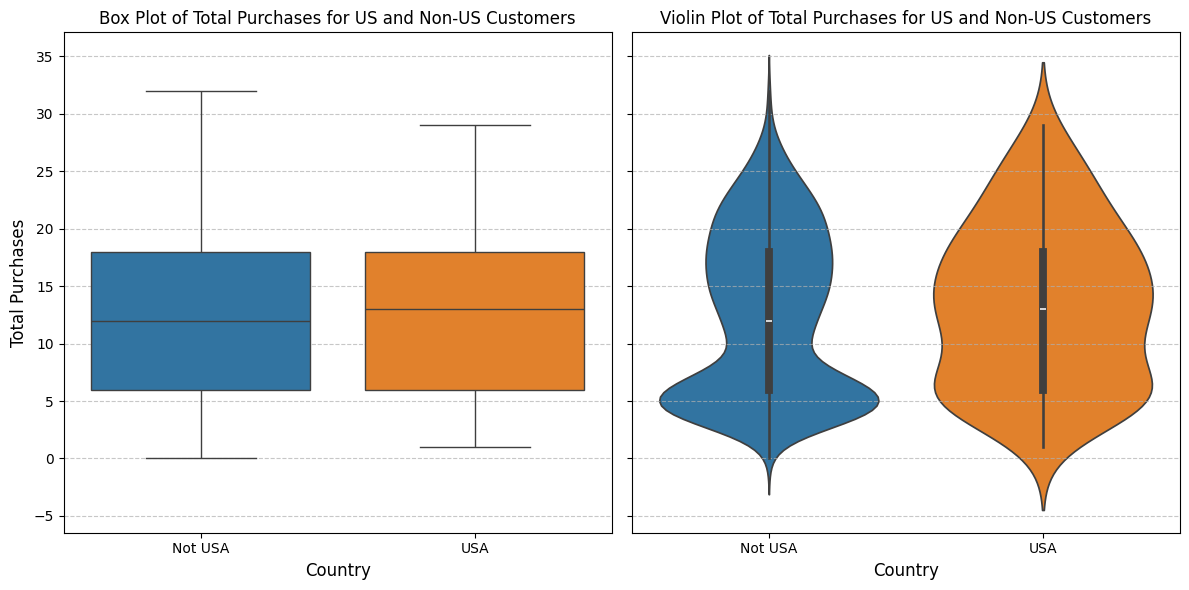

                 mean  median       std  count
Country_US                                    
False       12.507308    12.0  7.190538   2121
True        13.370370    13.0  6.989435    108


In [74]:
# Create a figure with two subplots side by side

reset_plot_settings()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Boxplot
sns.boxplot(
    x="Country_US", y="Total_Purchases", data=df, ax=ax1, hue="Country_US", legend=False
)
ax1.set_title("Box Plot of Total Purchases for US and Non-US Customers", fontsize=12)
ax1.set_ylabel("Total Purchases", fontsize=12)
ax1.set_xlabel("Country", fontsize=12)
ax1.set_xticks([0, 1], ["Not USA", "USA"])
ax1.grid(True, axis="y", linestyle="--", alpha=0.7)

# Violin Plot
sns.violinplot(
    x="Country_US", data=df, y="Total_Purchases", legend=False, ax=ax2, hue="Country_US"
)
ax2.set_title("Violin Plot of Total Purchases for US and Non-US Customers", fontsize=12)
ax2.set_xlabel("Country", fontsize=12)
ax2.set_xticks([0, 1], ["Not USA", "USA"])
ax2.grid(True, axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# Descriptive Statistics
current_stats = df.groupby('Country_US')['Total_Purchases'].agg(['mean','median','std','count'])
print(current_stats)

# Shapiro-Wilk test and plots show data is not normally distributed so a non-parametric
# test seems more appropriate

In [75]:
# Perform Mann-Whitney U Test (One-Tailed)
# H₀: The distributions of Total_Puchases for US and non-US customers are
#     identical (no difference in distribution).
# H₁: The distribution of Total_Purchases for US customers is stochastically
#     greater (US tends to have higher Total_Purchases for its customers).
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(us_purchases, non_us_purchases, alternative="greater")
print(f"Mann-Whitney U Test: statistic = {stat:.4f}, p-value = {p_value:.4f}")

# Interpretation
alpha = 0.05
if p_value <= alpha:
    print(
        "Reject H₀: Reject H₀, concluding there is evidence that US has higher Total_Purchases for its customers than the rest of the world."
    )
else:
    print(
        "Fail to reject H₀: No evidence that US has higher Total_Purchases for its customers than the rest of the world."
    )

Mann-Whitney U Test: statistic = 122899.5000, p-value = 0.0996
Fail to reject H₀: No evidence that US has higher Total_Purchases for its customers than the rest of the world.


In [76]:
# Why a t-test may be ok
# Large sample sizes (e.g., n > 30 or ideally n > 50 per group), due to the Central Limit Theorem (CLT).
# The CLT states that the sampling distribution of the mean approaches normality as sample size increases,
# even if the underlying data is non-normal.

print(f"Sample size for Country:\n{df['Country_US'].value_counts()}")
# Sample Size is Large: Both groups (Country_US = 1 and 0) have n > 50
# the CLT helps ensure the t-test is robust.

Sample size for Country:
Country_US
False    2121
True      108
Name: count, dtype: int64


In [77]:
# Perform Levene's test

# Purpose:
# •  Tests the null hypothesis (H₀) that the variances of the groups are equal.
# •  Alternative hypothesis (H₁): The variances are not equal.

# Variations of test:
# •  Standard Levene’s Test: Uses the group mean for calculating deviations.
# •  Modified Levene’s Test (Brown-Forsythe): Uses the group median instead of the mean,
#    which is more robust to non-normal data.

# Implications of test:
# •  If Levene’s test indicates unequal variances (p-value ≤ 0.05), use Welch’s t-test to compare means.
# •  If variances are equal, use the standard t-test.

from scipy.stats import levene
alpha = 0.05

stat, p_levene = levene(us_purchases, non_us_purchases, center='median')
print(f"\nLevene's Test: statistic = {stat:.4f}, p-value = {p_levene:.4f}")
print(f"{'Unequal variances' if p_levene < alpha else 'Equal variances'} (p {'<' if p_levene < alpha else '>='} {alpha})")


Levene's Test: statistic = 1.8860, p-value = 0.1698
Equal variances (p >= 0.05)


In [78]:
# Run standard parametric t-test since variances are equal

from scipy.stats import ttest_ind

print("\nStandard t-Test:")
stat, p_ttest = ttest_ind(
    us_purchases, non_us_purchases, alternative="greater", equal_var=True
)
print(f"t-test: statistic = {stat:.4f}, p-value = {p_ttest:.4f}")

if p_ttest <= alpha:
    print(
        "Reject H₀: Reject H₀, concluding there is evidence that US has higher Total_Purchases for its customers than the rest of the world."
    )
else:
    print(
        "Fail to reject H₀: No evidence that US has higher Total_Purchases for its customers than the rest of the world."
    )


Standard t-Test:
t-test: statistic = 1.2184, p-value = 0.1116
Fail to reject H₀: No evidence that US has higher Total_Purchases for its customers than the rest of the world.


In [79]:
# Conclusion
# Both the parametric test (Standard t-Test) and the non-parametric test (Mann-Whitney U Test)
# fail to reject H₀, meaning there is no evidence that Total_Purchases for US customers is greater than Total_Purchases for Non US Customers

# Step 8: Additional Visualizations

## a. Identify the top-performing products and those with the lowest revenue.

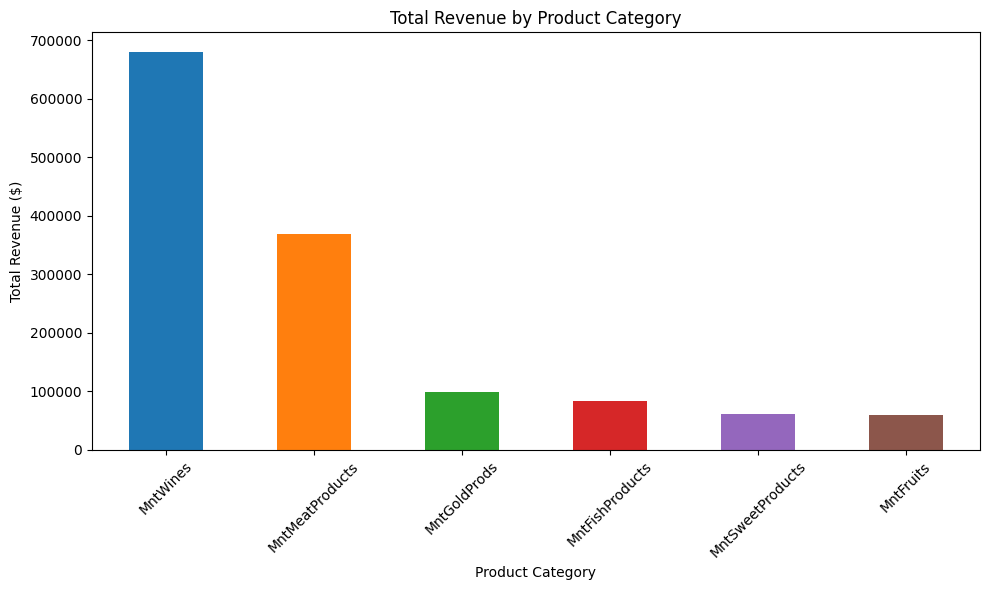

In [80]:
# a. Identify the top-performing products and those with the lowest revenue

# Calculate total revenue for each product
product_revenue = df[
    [
        "MntWines",
        "MntFruits",
        "MntMeatProducts",
        "MntFishProducts",
        "MntSweetProducts",
        "MntGoldProds",
    ]
].sum()

reset_plot_settings()

# Create bar plot showing revenue
plt.figure(figsize=(10, 6))

product_revenue.sort_values(ascending=False).plot(
    kind="bar", color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
)

plt.title("Total Revenue by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Total Revenue ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [81]:
# Print top and bottom products
print("Top-performing products:")
print(product_revenue.sort_values(ascending=False).head(3))
print("\nLowest-performing products:")
print(product_revenue.sort_values(ascending=True).head(3))

Top-performing products:
MntWines           679826
MntMeatProducts    368418
MntGoldProds        98328
dtype: int64

Lowest-performing products:
MntFruits           58731
MntSweetProducts    60543
MntFishProducts     83905
dtype: int64


### Results
Top-performing products:
- MntWines           679826
- MntMeatProducts    368418
- MntGoldProds        98328

Lowest-performing products:
- MntFruits           58731
- MntSweetProducts    60543
- MntFishProducts     83905

## b. Examine if there is a correlation between customers’ age and the acceptance rate of the last campaign

In [82]:
from scipy.stats import pointbiserialr

corr, p_value = pointbiserialr(df["Age"], df["Response"])
print(
    f"Point-Biserial Correlation between Age and Response: {corr:.3f} (p-value: {p_value:.3f})"
)

# What is Point-Biserial Correlation?
# Point-biserial correlation is chosen because it is a statistical measure that quantifies
# the linear relationship between a continuous variable and a binary variable.
# It's essentially a special case of the standard Pearson correlation coefficient,
# specifically designed for binary outcomes.

# Why I used
# In campaign analysis, you have:
# - Binary variable: Campaign response (Accepted = 1, Not Accepted = 0)
# - Continuous variable: Age (ranging from ~30 to 80+)

# Output: correlation ≈ -0.019, p-value ≈ 0.372, indicating a very weak, non-significant
# relationship. Younger customers may have a slight tendency to accept the campaign,
# but the effect is negligible.

Point-Biserial Correlation between Age and Response: -0.019 (p-value: 0.372)


In [83]:
# Statistics to use for age analysis for last campaign response
# Data will be used in plots

accepted = df[df["Response"] == 1]["Age"]
not_accepted = df[df["Response"] == 0]["Age"]

# Create age groups
bins = [0, 40, 50, 60, 70, 100]
labels = ["<40", "40-50", "50-60", "60-70", "70+"]
df["Age_Group"] = pd.cut(df["Age"], bins=bins, labels=labels, include_lowest=True)
print(df["Age_Group"].value_counts())

age_analysis = (
    df.groupby("Age_Group")
    .agg({"Response": ["sum", "count", "mean"], "Age": ["mean", "std"]})
    .round(3)
)

age_analysis.columns = [
    "Accepted_Count",
    "Total_Count",
    "Acceptance_Rate",
    "Mean_Age",
    "Age_SD",
]
age_analysis["Sample_Size_Category"] = pd.qcut(
    age_analysis["Total_Count"], q=3, labels=["Small", "Medium", "Large"]
)
print(age_analysis)

Age_Group
50-60    674
40-50    552
60-70    467
70+      315
<40      221
Name: count, dtype: int64
           Accepted_Count  Total_Count  Acceptance_Rate  Mean_Age  Age_SD  \
Age_Group                                                                   
<40                    36          221            0.163    36.774   2.631   
40-50                  84          552            0.152    46.293   2.873   
50-60                 101          674            0.150    55.202   2.847   
60-70                  63          467            0.135    65.694   2.863   
70+                    50          315            0.159    74.622   2.992   

          Sample_Size_Category  
Age_Group                       
<40                      Small  
40-50                    Large  
50-60                    Large  
60-70                   Medium  
70+                      Small  


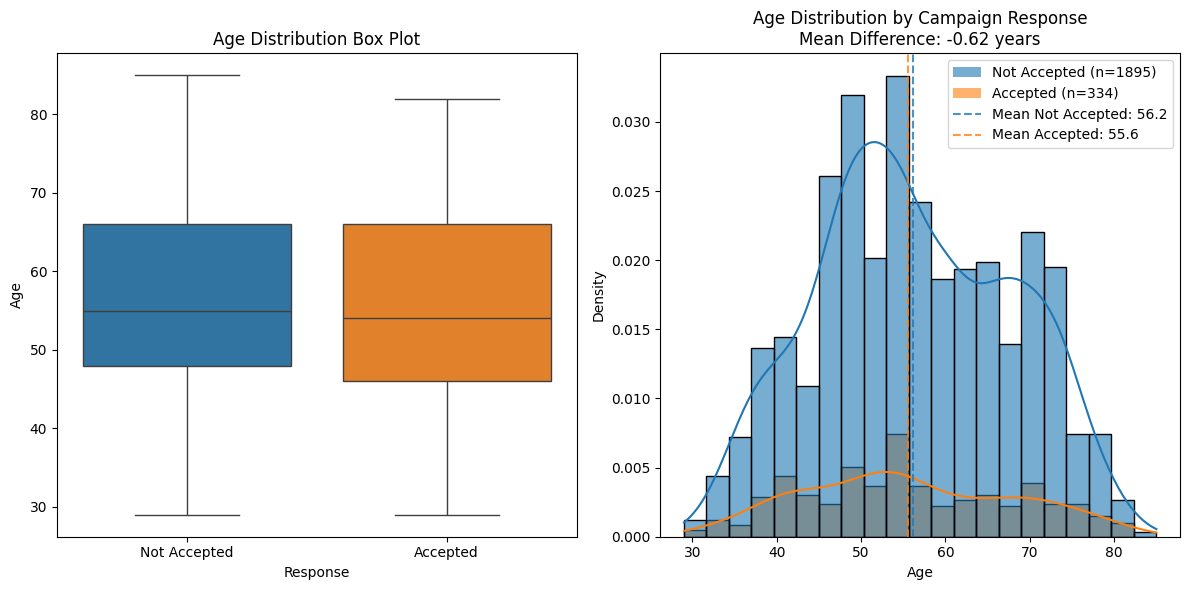

In [84]:
# Visualizations
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

reset_plot_settings()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Define colors upfront
# Use matplotlib's palette
sns.set_palette("tab10")
matplot_colors = sns.color_palette("tab10")
matplot_blue = matplot_colors[0]
matplot_orange = matplot_colors[1]

# Age group acceptance rates
acceptance_rates = age_analysis["Acceptance_Rate"]
sample_sizes = age_analysis["Total_Count"]

# Box Plot with statistical results
sns.boxplot(
    x="Response",
    y="Age",
    data=df,
    hue="Response",
    ax=ax1,
    palette="tab10",
    legend=False,
)
ax1.set_xlabel("Response")
ax1.set_xticks([0, 1], ["Not Accepted", "Accepted"])
ax1.set_title("Age Distribution Box Plot")
ax1.set_ylabel("Age")

# Distribution comparison with statistical annotation
# Create subsets
not_accepted = df[df["Response"] == 0]["Age"]
accepted = df[df["Response"] == 1]["Age"]

# Create labels with counts
df["Response_Label"] = df["Response"].map(
    {0: f"Not Accepted (n={len(not_accepted)})", 1: f"Accepted (n={len(accepted)})"}
)

# Create histogram with specific colors
sns.histplot(
    data=df,
    x="Age",
    hue="Response_Label",
    kde=True,
    stat="density",
    ax=ax2,
    alpha=0.6,
    hue_order=[
        f"Not Accepted (n={len(not_accepted)})",
        f"Accepted (n={len(accepted)})",
    ],
    palette="tab10",
    legend=False,
)

# Add mean lines with matching colors
ax2.axvline(not_accepted.mean(), color=matplot_blue, linestyle="--", alpha=0.8)
ax2.axvline(accepted.mean(), color=matplot_orange, linestyle="--", alpha=0.8)

# Create legend manually
legend_elements = [
    Patch(
        facecolor=matplot_blue, alpha=0.6, label=f"Not Accepted (n={len(not_accepted)})"
    ),
    Patch(facecolor=matplot_orange, alpha=0.6, label=f"Accepted (n={len(accepted)})"),
    Line2D(
        [0],
        [0],
        color=matplot_blue,
        linestyle="--",
        alpha=0.8,
        label=f"Mean Not Accepted: {not_accepted.mean():.1f}",
    ),
    Line2D(
        [0],
        [0],
        color=matplot_orange,
        linestyle="--",
        alpha=0.8,
        label=f"Mean Accepted: {accepted.mean():.1f}",
    ),
]

ax2.legend(handles=legend_elements)

# Set titles and labels
ax2.set_title(
    f"Age Distribution by Campaign Response\n"
    f"Mean Difference: {accepted.mean() - not_accepted.mean():.2f} years"
)
ax2.set_xlabel("Age")
ax2.set_ylabel("Density")


plt.tight_layout()
plt.show()

In [85]:
# Results and possible conclusions from intial visualizations show that age does
# not seem to be correlated strongly to age. This is based on the point-biserial
# correlation and the boxplots and histogram plots which show if anything
# younger customers have a slight tendency to accept the campaign.

# Below several other visualizations are created to explore the age versus
# campaign response.

           Accepted_Count  Total_Count  Acceptance_Rate  Mean_Age  Age_SD  \
Age_Group                                                                   
<40                    36          221            0.163    36.774   2.631   
40-50                  84          552            0.152    46.293   2.873   
50-60                 101          674            0.150    55.202   2.847   
60-70                  63          467            0.135    65.694   2.863   
70+                    50          315            0.159    74.622   2.992   

          Sample_Size_Category  
Age_Group                       
<40                      Small  
40-50                    Large  
50-60                    Large  
60-70                   Medium  
70+                      Small  


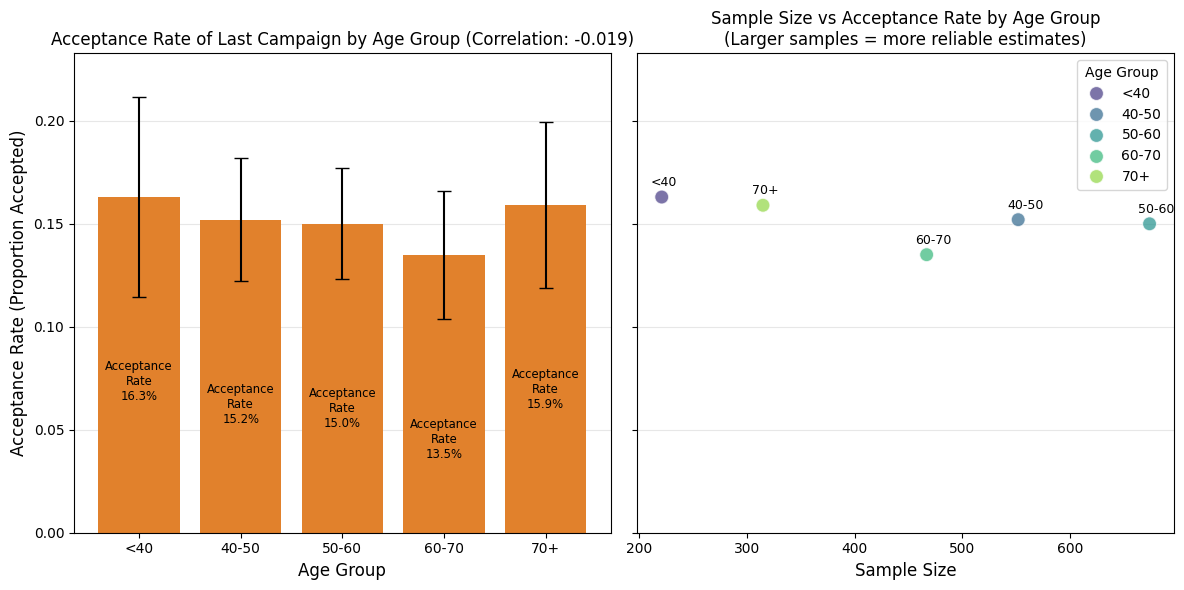

In [86]:
reset_plot_settings()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Bar plot of acceptance rates
# Age group acceptance rates with confidence intervals
acceptance_rates = age_analysis["Acceptance_Rate"]
sample_sizes = age_analysis["Total_Count"]

# Calculate 95% confidence intervals for proportions
z_score = 1.96  # 95% confidence
ci_lower = []
ci_upper = []

for rate, n in zip(acceptance_rates, sample_sizes):
    se = np.sqrt(rate * (1 - rate) / n)  # Standard error for proportion
    ci_lower.append(max(0, rate - z_score * se))
    ci_upper.append(min(1, rate + z_score * se))

# print(age_analysis[['Age_Group','Acceptance_Rate','Total_Count']])
print(age_analysis)

bars = sns.barplot(
    x="Age_Group",
    y="Acceptance_Rate",
    data=age_analysis,
    errorbar=None,
    color=matplot_orange,
    ax=ax1,
)
ax1.errorbar(
    x=range(len(acceptance_rates)),
    y=acceptance_rates,
    yerr=[acceptance_rates - ci_lower, ci_upper - acceptance_rates],
    fmt="none",
    c="black",
    capsize=5,
)
for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height - 0.1,
        f"Acceptance\nRate\n{(age_analysis['Acceptance_Rate'].iloc[i]) * 100}%",
        ha="center",
        va="bottom",
        fontsize="small",
    )
ax1.set_title(
    f"Acceptance Rate of Last Campaign by Age Group (Correlation: {corr:.3f})",
    fontsize=12,
)
ax1.set_xlabel("Age Group", fontsize=12)
ax1.set_ylabel("Acceptance Rate (Proportion Accepted)", fontsize=12)
ax1.grid(True, axis="y", alpha=0.3)
ax1.set_axisbelow(True)
ax1.set_ylim(0, max(ci_upper) * 1.1)


# Scatterplot showing age group sample size and acceptance rate
age_analysis_reset = age_analysis.reset_index()

sns.scatterplot(
    data=age_analysis_reset,
    x="Total_Count",
    y="Acceptance_Rate",
    hue="Age_Group",
    s=100,
    alpha=0.7,
    ax=ax2,
    palette="viridis",
)

# Add annotations
for i, row in age_analysis_reset.iterrows():
    ax2.annotate(
        row["Age_Group"],
        (row["Total_Count"], row["Acceptance_Rate"]),
        xytext=(-8, 8),
        textcoords="offset points",
        fontsize=9,
    )

ax2.set_xlabel("Sample Size", fontsize=12)
ax2.set_ylabel("Acceptance Rate", fontsize=12)
ax2.set_title(
    "Sample Size vs Acceptance Rate by Age Group\n(Larger samples = more reliable estimates)",
    fontsize=12,
)
ax2.grid(True, axis="y", alpha=0.3)
ax2.set_axisbelow(True)
ax2.legend(title="Age Group", loc="upper right")

plt.tight_layout()
plt.show()

In [87]:
# Cleanup and summary analysis creation
df.drop("Response_Label", axis=1, inplace=True)
age_analysis_reset = age_analysis.copy()
age_analysis_reset["Acceptance_Rate_Percent"] = (
    age_analysis_reset["Acceptance_Rate"] * 100
)
print(age_analysis_reset[["Sample_Size_Category", "Acceptance_Rate_Percent"]])

          Sample_Size_Category  Acceptance_Rate_Percent
Age_Group                                              
<40                      Small                     16.3
40-50                    Large                     15.2
50-60                    Large                     15.0
60-70                   Medium                     13.5
70+                      Small                     15.9


In [88]:
# Output: correlation, boxplots, histogram plots, bar plot with error bars and scatter
# plot show no significant age to campaign acceptance relationship

# Primary Findings
# •  Minimal Age Effect: The most striking finding is that age has virtually no meaningful
#    relationship with campaign acceptance. The correlation of -0.019 is essentially zero,
#    indicating no practical relationship between age and response rates (very weak,
#    non-significant relationship).
# •  Consistent Acceptance Across Age Groups: The acceptance rates across all age groups
#    cluster between 13-16%, with the 60-70 age group showing the lowest rate at approximately
#    13% and the <40 and 70+ groups showing the highest at around 16%. This 3
#    percentage point difference is quite small from a practical standpoint.

# Statistical Considerations
# •  Sample Size Reliability: The scatterplot reveals that the 60-70 age group has the
#    smallest sample size (467), while the 50-60 group has the largest (674).
#    The smaller sample size for the 60-70 group may contribute to the slightly lower observed
#    acceptance rate, but the confidence intervals shown in the bar chart suggest these
#    differences aren't statistically significant.
# •  Age Distribution Insights: The first chart shows that both accepted and non-accepted
#    groups have very similar age distributions, with mean ages differing by only 0.62 years
#    (56.2 vs 55.6). This minimal difference reinforces that age is not a meaningful predictor.

# Result
# Campaign acceptance does not seem to be correlated strongly to age.

## c. Determine the country with the highest number of customers who accepted the last campaign.

In [89]:
# Define country columns (dummy-encoded)

country_columns = [
    "Country_AUS",
    "Country_CA",
    "Country_GER",
    "Country_IND",
    "Country_ME",
    "Country_SA",
    "Country_SP",
    "Country_US",
]

# Verify country columns exist

missing_cols = [col for col in country_columns if col not in df.columns]
if missing_cols:
    print(f"Warning: Missing country columns: {missing_cols}")
    country_columns = [col for col in country_columns if col in df.columns]

print("Available country columns:", country_columns)

# Display basic information about the dataset

print("\nDataset Overview:")
print(f"Total customers: {len(df):,}")
print(f"Total countries: {len(country_columns)}")
print(f"Customers who accepted last campaign: {df['Response'].sum():,}")
print(f"Overall acceptance rate: {(df['Response'].sum() / len(df) * 100):.2f}%")

Available country columns: ['Country_AUS', 'Country_CA', 'Country_GER', 'Country_IND', 'Country_ME', 'Country_SA', 'Country_SP', 'Country_US']

Dataset Overview:
Total customers: 2,229
Total countries: 8
Customers who accepted last campaign: 334
Overall acceptance rate: 14.98%


In [90]:
# Calculate key metrics by country using dummy columns

country_stats = []

for country_col in country_columns:
    # Extract country name from column (remove ‘Country_’ prefix)
    country_name = country_col.replace("Country_", "")

    # Filter customers from this country (where dummy variable = 1)
    country_customers = df[df[country_col] == 1]

    if len(country_customers) > 0:
        total_customers = len(country_customers)
        accepted_customers = country_customers["Response"].sum()
        acceptance_rate = (accepted_customers / total_customers) * 100

        country_stats.append(
            {
                "Country": country_name,
                "Total_Customers": total_customers,
                "Accepted_Customers": accepted_customers,
                "Acceptance_Rate": acceptance_rate,
            }
        )

In [91]:
# Convert to DataFrame

country_stats = pd.DataFrame(country_stats)
country_stats = country_stats.sort_values("Accepted_Customers", ascending=False)
country_stats = country_stats.reset_index(drop=True)
# print(country_stats.columns)

print("\n" + "="*60)
print("COUNTRY PERFORMANCE SUMMARY")
print("="*60)
country_stats_perf = country_stats.copy()
country_stats_perf = country_stats_perf.set_index("Country")
print(country_stats_perf.round(2))

# Find the answer to our main question
top_count = int(country_stats["Accepted_Customers"].max())
stat_count = country_stats[country_stats["Accepted_Customers"] == top_count]
top_country = stat_count["Country"].iloc[0]
top_rate = country_stats["Acceptance_Rate"].max()
stat_rate = country_stats[country_stats["Acceptance_Rate"] == top_rate]
top_rate_country = stat_rate["Country"].iloc[0]

# print(top_count)
# print(top_rate)
# print(country_stats[country_stats['Acceptance_Rate']== top_rate])
# stat1 = country_stats[country_stats['Accepted_Customers']== top_count]
# print(stat_rate['Total_Customers'].iloc[0])


print(f"\n{top_country} has the highest number of customers ({top_count}) who accepted the last campaign")
print(f"{top_country}'s acceptance rate for the last campaign was {round(stat_count['Acceptance_Rate'].iloc[0],3)}%")
print(f"{top_rate_country} has the highest acceptance rate ({round(top_rate,3)}%) for the last campaign")
print(f"However the total number of {top_rate_country} customers ({stat_rate['Total_Customers'].iloc[0]})\
# and the number of {top_rate_country} customers that accepted ({stat_rate['Accepted_Customers'].iloc[0]}) are low.")
print(f"In comparison the total number of {top_country} customers ({stat_count['Total_Customers'].iloc[0]})\
# and the number of {top_country} customers that accepted ({stat_count['Accepted_Customers'].iloc[0]}) are much higher.")


COUNTRY PERFORMANCE SUMMARY
         Total_Customers  Accepted_Customers  Acceptance_Rate
Country                                                      
SP                  1091                 176            16.13
SA                   334                  52            15.57
CA                   267                  38            14.23
AUS                  160                  23            14.37
GER                  120                  17            14.17
IND                  146                  13             8.90
US                   108                  13            12.04
ME                     3                   2            66.67

SP has the highest number of customers (176) who accepted the last campaign
SP's acceptance rate for the last campaign was 16.132%
ME has the highest acceptance rate (66.667%) for the last campaign
However the total number of ME customers (3)# and the number of ME customers that accepted (2) are low.
In comparison the total number of SP customers (

In [92]:
print(country_stats)

  Country  Total_Customers  Accepted_Customers  Acceptance_Rate
0      SP             1091                 176        16.131989
1      SA              334                  52        15.568862
2      CA              267                  38        14.232210
3     AUS              160                  23        14.375000
4     GER              120                  17        14.166667
5     IND              146                  13         8.904110
6      US              108                  13        12.037037
7      ME                3                   2        66.666667


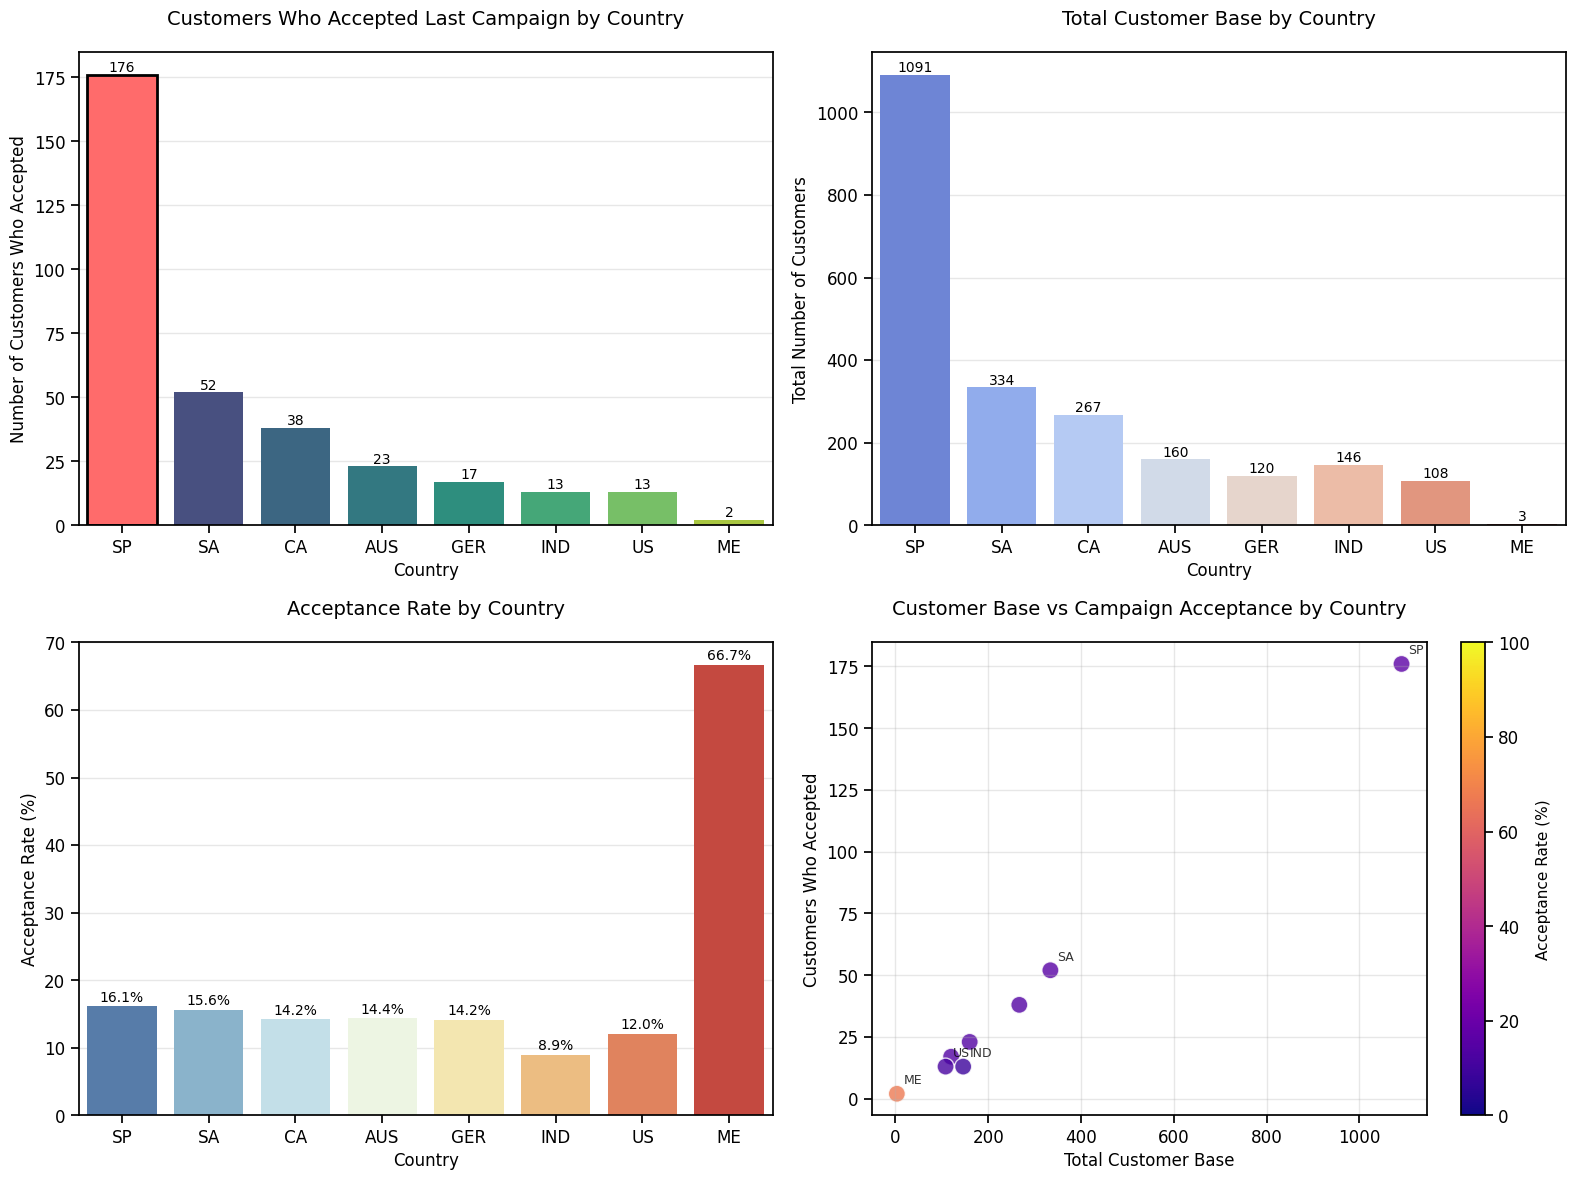

In [93]:
# Create visualizations

# Set the style for better-looking plots
reset_plot_settings()

plt.style.use("default")
# sns.set_palette('husl')
sns.set_context("notebook", font_scale=1.1)

# 2x2 grid
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# 1. Main Answer: Bar plot of customers who accepted by country
sns.barplot(
    data=country_stats.reset_index(),
    x="Country",
    y="Accepted_Customers",
    ax=ax1,
    palette="viridis",
)
ax1.set_title("Customers Who Accepted Last Campaign by Country", fontsize=14, pad=20)
ax1.set_ylabel("Number of Customers Who Accepted", fontsize=12)
ax1.set_xlabel("Country", fontsize=12)
ax1.grid(True, axis="y", alpha=0.3)
ax1.set_axisbelow(True)

# Highlight the top country with a different color and annotation
bars = ax1.patches
max_height = max([bar.get_height() for bar in bars])
bars[0].set_color("#FF6B6B")  # Highlight top country in red
bars[0].set_edgecolor("black")
bars[0].set_linewidth(2)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=10,
    )


# 2. Total customers by country (context)
sns.barplot(
    data=country_stats.reset_index(),
    x="Country",
    y="Total_Customers",
    ax=ax2,
    palette="coolwarm",
)
ax2.set_title("Total Customer Base by Country", fontsize=14, pad=20)
ax2.set_ylabel("Total Number of Customers", fontsize=12)
ax2.set_xlabel("Country", fontsize=12)
ax2.grid(True, axis="y", alpha=0.3)
ax2.set_axisbelow(True)

# Add value labels
for i, bar in enumerate(ax2.patches):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# 3. Acceptance rates by country
sns.barplot(
    data=country_stats.reset_index(),
    x="Country",
    y="Acceptance_Rate",
    ax=ax3,
    palette="RdYlBu_r",
)
ax3.set_title("Acceptance Rate by Country", fontsize=14, pad=20)
ax3.set_ylabel("Acceptance Rate (%)", fontsize=12)
ax3.set_xlabel("Country", fontsize=12)

# Add percentage labels
for i, bar in enumerate(ax3.patches):
    height = bar.get_height()
    ax3.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.3,
        f"{height:.1f}%",
        ha="center",
        va="bottom",
        fontsize="10",
    )
ax3.grid(True, axis="y", alpha=0.3)
ax3.set_axisbelow(True)

# 4. Scatter plot: Total customers vs Accepted customers
# Create scatter plot with country data
scatter = sns.scatterplot(
    data=country_stats,
    x="Total_Customers",
    y="Accepted_Customers",
    hue="Acceptance_Rate",
    hue_norm=(0, 100),  # Set color scale from 0-100%
    s=150,
    alpha=0.8,
    ax=ax4,
    palette="plasma",
    legend=False,
)

# Selective labeling - Label outliers or extreme values
high_acceptance = country_stats["Acceptance_Rate"] > country_stats[
    "Acceptance_Rate"
].quantile(0.75)
low_acceptance = country_stats["Acceptance_Rate"] < country_stats[
    "Acceptance_Rate"
].quantile(0.25)
high_customers = country_stats["Total_Customers"] > country_stats[
    "Total_Customers"
].quantile(0.75)

for idx, row in country_stats.iterrows():
    if (
        high_acceptance.iloc[idx]
        or low_acceptance.iloc[idx]
        or high_customers.iloc[idx]
    ):
        ax4.annotate(
            row["Country"],
            xy=(row["Total_Customers"], row["Accepted_Customers"]),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=9,
            alpha=0.8,
            ha="left",  # horizontal alignment
            va="bottom",
        )  # vertical alignment

# Add colorbar/legend for acceptance rate
norm = plt.Normalize(vmin=0, vmax=100)
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax4)
cbar.set_label("Acceptance Rate (%)", fontsize=11)

# Set plot titles and labels
ax4.set_title("Customer Base vs Campaign Acceptance by Country", fontsize=14, pad=20)
ax4.set_xlabel("Total Customer Base", fontsize=12)
ax4.set_ylabel("Customers Who Accepted", fontsize=12)

# Add grid for better readability
ax4.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

In [94]:
# Summary statistics table

print("\n" + "=" * 80)
print("DETAILED INSIGHTS")
print("=" * 80)

# Create a more detailed summary

detailed_stats = country_stats.copy()
detailed_stats["Market_Share_Total"] = (
    detailed_stats["Total_Customers"] / len(df) * 100
).round(1)
detailed_stats["Market_Share_Accepted"] = (
    detailed_stats["Accepted_Customers"] / df["Response"].sum() * 100
).round(1)

detailed_stats = detailed_stats.rename(
    columns={"Accepted_Customers": "Customers_Accepted"}
)

# Set the 'Country' column as the index
detailed_stats = detailed_stats.set_index("Country")

print(round(detailed_stats, 2))


DETAILED INSIGHTS
         Total_Customers  Customers_Accepted  Acceptance_Rate  \
Country                                                         
SP                  1091                 176            16.13   
SA                   334                  52            15.57   
CA                   267                  38            14.23   
AUS                  160                  23            14.37   
GER                  120                  17            14.17   
IND                  146                  13             8.90   
US                   108                  13            12.04   
ME                     3                   2            66.67   

         Market_Share_Total  Market_Share_Accepted  
Country                                             
SP                     48.9                   52.7  
SA                     15.0                   15.6  
CA                     12.0                   11.4  
AUS                     7.2                    6.9  
GER         

In [95]:
# Key insights
total_accepted = df["Response"].sum()
print('\nKEY INSIGHTS:')
print(f'• {top_country} leads with {top_count} customers accepting the campaign ({(top_count/total_accepted*100):.1f}% of all acceptances)')
print(f"• {top_country} has {int(detailed_stats.loc[top_country, 'Total_Customers'])} total customers ({detailed_stats.loc[top_country, 'Market_Share_Total']:.1f}% of customer base)")
print(f"• {top_country}’s acceptance rate for the last campaign is {detailed_stats.loc[top_country, 'Acceptance_Rate']:.2f}% (vs {(total_accepted/len(df)*100):.2f}% overall)")

# Efficiency insight
most_efficient = detailed_stats.loc[detailed_stats["Acceptance_Rate"].idxmax()]
most_efficient_country = detailed_stats["Acceptance_Rate"].idxmax()
print(f"• {most_efficient_country} with a {most_efficient['Acceptance_Rate']:.1f}% acceptance rate has the highest accepance rate for the last campaign")
print(f"  (but only {int(most_efficient['Customers_Accepted'])} total acceptances vs {top_country}’s {top_count})")
# Most efficient country: ME with 66.7% acceptance rate
# (but only 2 total acceptances vs SP’s 176)


KEY INSIGHTS:
• SP leads with 176 customers accepting the campaign (52.7% of all acceptances)
• SP has 1091 total customers (48.9% of customer base)
• SP’s acceptance rate for the last campaign is 16.13% (vs 14.98% overall)
• ME with a 66.7% acceptance rate has the highest accepance rate for the last campaign
  (but only 2 total acceptances vs SP’s 176)


In [96]:
# KEY INSIGHTS:
# • SP leads with 176 customers accepting the campaign (52.7% of all acceptances)
# • SP has 1091 total customers (48.9% of customer base)
# • SP’s acceptance rate for the last campaign is 16.13% (vs 14.98% overall)
# • ME with a 66.7% acceptance rate has the highest accepance rate for the last campaign
#   (but only 2 total acceptances vs SP’s 176)

## d. Investigate if there is a discernible pattern in the number of children at home and the total expenditure.

In [97]:
# Children at Home vs Total Expenditure Analysis
# Investigating patterns between household children count and spending behavior

# Examine the data
print("CHILDREN AT HOME vs TOTAL EXPENDITURE ANALYSIS")
print("=" * 60)

# print(f"Dataset Shape: {df.shape}")
print(f"Total Records: {len(df)}")

# Data summaries
print("\nDATA SUMMARIZATION")
print("-" * 30)

print(f"Children count range: {df['Total_Children'].min()} to {df['Total_Children'].max()}")
print(f"Expenditure range: ${df['Total_Spending'].min()} to ${df['Total_Spending'].max()}")

# Examine distribution of children
children_dist = df['Total_Children'].value_counts().sort_index()
print("\nDistribution of children at home:")
for children, count in children_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  {children} children: {count:4d} households ({percentage:5.1f}%)")

# Calculate summary statistics by number of children
print("\nSUMMARY STATISTICS BY CHILDREN COUNT")
print("-" * 45)

print(df.groupby('Total_Children')['Total_Spending'].describe().round(2))

CHILDREN AT HOME vs TOTAL EXPENDITURE ANALYSIS
Total Records: 2229

DATA SUMMARIZATION
------------------------------
Children count range: 0 to 3
Expenditure range: $5 to $2525

Distribution of children at home:
  0 children:  633 households ( 28.4%)
  1 children: 1123 households ( 50.4%)
  2 children:  420 households ( 18.8%)
  3 children:   53 households (  2.4%)

SUMMARY STATISTICS BY CHILDREN COUNT
---------------------------------------------
                 count     mean     std  min    25%     50%     75%     max
Total_Children                                                             
0                633.0  1106.37  642.97  6.0  636.0  1189.0  1587.0  2525.0
1               1123.0   473.22  477.20  5.0   64.0   306.0   805.0  2194.0
2                420.0   246.28  311.63  9.0   45.0    92.5   316.5  1750.0
3                 53.0   274.60  414.28  8.0   35.0    88.0   348.0  1616.0


In [98]:
# Correlation analysis
correlation = df['Total_Children'].corr(df['Total_Spending'])
print(f"\nPearson correlation coefficient: {correlation:.4f}")
print(f"Correlation interpretation: {'Strong negative' if correlation < -0.5 else 'Moderate negative' if correlation < -0.3 else 'Weak negative' if correlation < 0 else 'Positive'}")


Pearson correlation coefficient: -0.4995
Correlation interpretation: Moderate negative


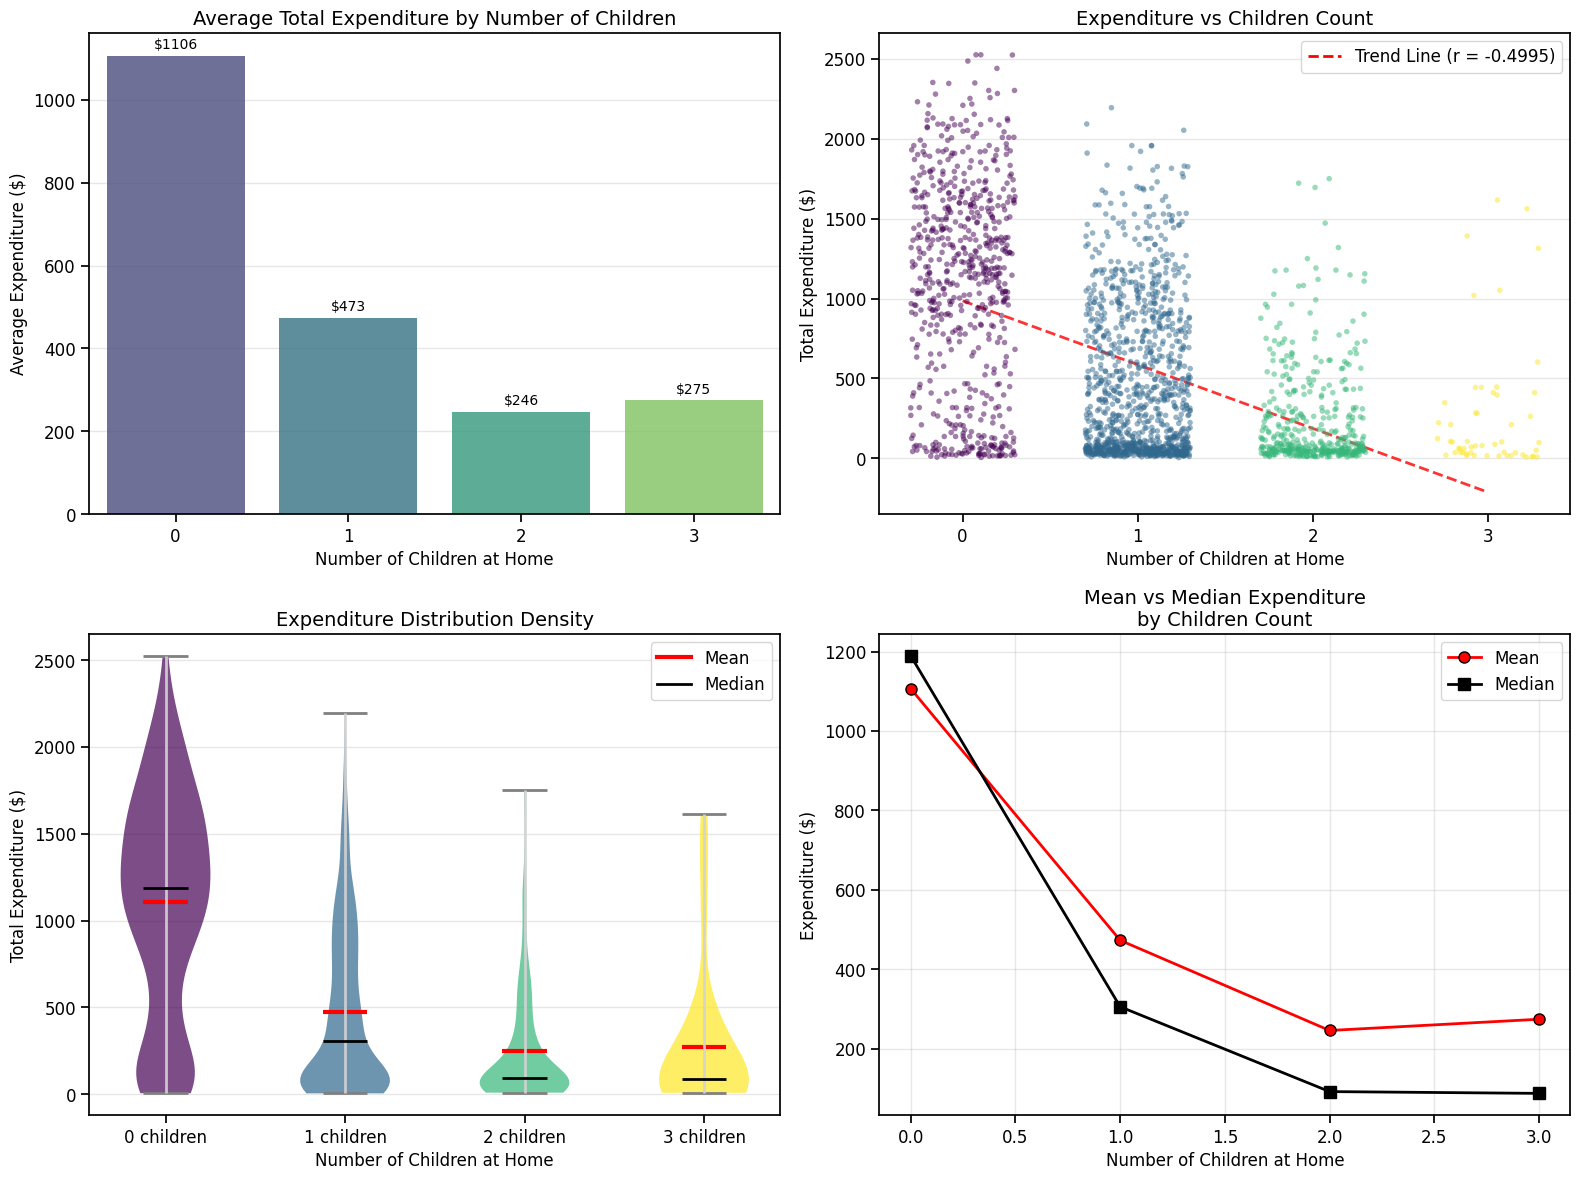

In [99]:
# Create visualizations

from matplotlib.lines import Line2D

# Set style for better-looking plots
reset_plot_settings()

# plt.style.use('seaborn-v0_8')
plt.style.use("default")
sns.set_palette("viridis")
sns.set_context("notebook", font_scale=1.1)

# 2x2 grid
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# 1. Average Expenditure by Children Count (Bar Plot)
ax1.set_axisbelow(True)
ax1.grid(True, axis="y", alpha=0.3, zorder=0)

sns.barplot(
    data=df,
    x="Total_Children",
    y="Total_Spending",
    estimator="mean",
    ax=ax1,
    palette="viridis",
    alpha=0.8,
    errorbar=None,
)

# Add value labels on bars
bars = ax1.patches

for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 10,
        f"${height:.0f}",
        fontsize=10,
        ha="center",
        va="bottom",
    )

ax1.set_title("Average Total Expenditure by Number of Children", fontsize=14)
ax1.set_xlabel("Number of Children at Home", fontsize=12)
ax1.set_ylabel("Average Expenditure ($)", fontsize=12)

# 2. Scatter plot with jitter
ax2.set_axisbelow(True)
ax2.grid(True, axis="y", alpha=0.3, zorder=0)

sns.stripplot(
    data=df,
    x="Total_Children",
    y="Total_Spending",
    size=4,
    alpha=0.5,
    jitter=0.3,
    ax=ax2,
    hue="Total_Children",
    palette="viridis",
    legend=False,
)

# Trendline
sns.regplot(
    data=df,
    x="Total_Children",
    y="Total_Spending",
    scatter=False,
    color="red",
    ci=None,
    ax=ax2,
    line_kws={
        "linestyle": "--",
        "alpha": 0.8,
        "linewidth": 2,
        "label": f"Trend Line (r={correlation:.3f})",
    },
)

# Create custom legend

# Add trend line to legend
legend_elements = []
legend_elements.append(
    Line2D(
        [0],
        [0],
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Trend Line (r = {correlation:.4f})",
    )
)

ax2.legend(handles=legend_elements, loc="best")

ax2.set_title("Expenditure vs Children Count", fontsize=14)
ax2.set_xlabel("Number of Children at Home", fontsize=12)
ax2.set_ylabel("Total Expenditure ($)", fontsize=12)

# 3. Violin Plot for Detailed Distribution
ax3.set_axisbelow(True)
ax3.grid(True, axis="y", alpha=0.3, zorder=0)

violin_data = []
violin_labels = []
for children in sorted(df["Total_Children"].unique()):
    data = df[df["Total_Children"] == children]["Total_Spending"].values
    if len(data) > 10:  # Only include if enough data points
        violin_data.append(data)
        violin_labels.append(f"{children} children")

parts = ax3.violinplot(
    violin_data,
    positions=range(len(violin_data)),
    showmeans=True,
    showmedians=True,
    showextrema=True,
)

# Get viridis colors
n_violins = len(violin_data)
colors = plt.cm.viridis(np.linspace(0, 1, n_violins))

for pc, color in zip(parts["bodies"], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

if "cbars" in parts:
    parts["cbars"].set_color("lightgrey")
    parts["cbars"].set_linewidth(2)
    parts["cbars"].set_alpha(0.9)

# Customize other elements
if "cmeans" in parts:
    parts["cmeans"].set_color("red")
    parts["cmeans"].set_linewidth(3)

if "cmedians" in parts:
    parts["cmedians"].set_color("black")
    parts["cmedians"].set_linewidth(2)

if "cmins" in parts:
    parts["cmins"].set_color("gray")
    parts["cmins"].set_linewidth(2)

if "cmaxes" in parts:
    parts["cmaxes"].set_color("gray")
    parts["cmaxes"].set_linewidth(2)

ax3.set_xticks(range(len(violin_labels)), violin_labels)
ax3.set_title("Expenditure Distribution Density", fontsize=14)
ax3.set_xlabel("Number of Children at Home", fontsize=12)
ax3.set_ylabel("Total Expenditure ($)", fontsize=12)

# Add legend

legend_elements = [
    Line2D([0], [0], color="red", linewidth=3, label="Mean"),
    Line2D([0], [0], color="black", linewidth=2, label="Median"),
]
ax3.legend(handles=legend_elements, loc="upper right")

# 4. Median vs Mean Comparison
ax4.set_axisbelow(True)
ax4.grid(True, alpha=0.3, zorder=0)

children_counts = sorted(df["Total_Children"].unique())
means = [
    df[df["Total_Children"] == c]["Total_Spending"].mean() for c in children_counts
]
medians = [
    df[df["Total_Children"] == c]["Total_Spending"].median() for c in children_counts
]

ax4.plot(
    children_counts,
    means,
    "o-",
    linewidth=2,
    markersize=8,
    label="Mean",
    color="red",
    markeredgecolor="black",
)
ax4.plot(
    children_counts,
    medians,
    "s-",
    linewidth=2,
    markersize=8,
    label="Median",
    color="black",
    markeredgecolor="black",
)

ax4.set_title("Mean vs Median Expenditure\nby Children Count", fontsize=14)
ax4.set_xlabel("Number of Children at Home", fontsize=12)
ax4.set_ylabel("Expenditure ($)", fontsize=12)
ax4.legend()

plt.tight_layout()
plt.show()


In [100]:
# Additional Analysis: Effect Size and Practical Significance
print("\nDETAILED FINDINGS & INSIGHTS")
print("=" * 40)

# Calculate percentage decrease in spending
spending_0_children = df[df['Total_Children']==0]['Total_Spending'].mean()
spending_1_children = df[df['Total_Children']==1]['Total_Spending'].mean()
spending_2_children = df[df['Total_Children']==2]['Total_Spending'].mean()
spending_3_children = df[df['Total_Children']==3]['Total_Spending'].mean()

decrease_1_child = ((spending_0_children - spending_1_children) / spending_0_children) * 100
decrease_2_children = ((spending_0_children - spending_2_children) / spending_0_children) * 100
decrease_3_children = ((spending_0_children - spending_3_children) / spending_0_children) * 100

print("\nEXPENDITURE:")
print(f"• 0 children: ${spending_0_children:.0f} average expenditure")
print(f"• 1 child:    ${spending_1_children:.0f} average expenditure ({decrease_1_child:.1f}% decrease)")
print(f"• 2 children: ${spending_2_children:.0f} average expenditure ({decrease_2_children:.1f}% decrease)")
print(f"• 3 children: ${spending_3_children:.0f} average expenditure ({decrease_3_children:.1f}% decrease)")

print("\nIMPLICATIONS:")
print(f"• Childless households represent {children_dist[0]/len(df)*100:.1f}% of customers but highest value")
print(f"• Average spending ratio (0 vs 1 child): {spending_0_children/spending_1_children:.1f}:1")
print(f"• Average spending ratio (0 vs 2 children): {spending_0_children/spending_2_children:.1f}:1")
print(f"• Average spending ratio (0 vs 3+ children): {spending_0_children/spending_3_children:.1f}:1")
print("• Clear market segmentation opportunity based on family status")

print("\nCONCLUSION:")
print("• There is an inverse relationship between")
print("  the number of children at home and total expenditure.")
print("• This pattern is consistent across all statistical measures")

# Create a final summary table
print("\nSUMMARY TABLE:")
print("=" * 80)
summary_display = df.groupby('Total_Children')['Total_Spending'].agg([
    ('Sample Size', 'count'),
    ('Average Spending', 'mean'),
    ('Median Spending', 'median'),
    ('Standard Deviation', 'std')
]).copy() # type: ignore
# print(summary_display.round(2))

summary_display = summary_display.round(2)
summary_display['% of Total'] = (summary_display['Sample Size'] / len(df) * 100).round(1)
summary_display['Spending Ratio'] = (summary_display['Average Spending'] / spending_0_children).round(2)
summary_display = summary_display.reset_index()
summary_display = summary_display.rename(columns={'Total_Children': 'Number of Children'})
summary_display = summary_display.set_index('Number of Children')
print(summary_display.to_string())


DETAILED FINDINGS & INSIGHTS

EXPENDITURE:
• 0 children: $1106 average expenditure
• 1 child:    $473 average expenditure (57.2% decrease)
• 2 children: $246 average expenditure (77.7% decrease)
• 3 children: $275 average expenditure (75.2% decrease)

IMPLICATIONS:
• Childless households represent 28.4% of customers but highest value
• Average spending ratio (0 vs 1 child): 2.3:1
• Average spending ratio (0 vs 2 children): 4.5:1
• Average spending ratio (0 vs 3+ children): 4.0:1
• Clear market segmentation opportunity based on family status

CONCLUSION:
• There is an inverse relationship between
  the number of children at home and total expenditure.
• This pattern is consistent across all statistical measures

SUMMARY TABLE:
                    Sample Size  Average Spending  Median Spending  Standard Deviation  % of Total  Spending Ratio
Number of Children                                                                                                
0                           633  

In [101]:
# DETAILED FINDINGS & INSIGHTS
# ========================================

# EXPENDITURE:
# • 0 children: $1106 average expenditure
# • 1 child:    $473 average expenditure (57.2% decrease)
# • 2 children: $246 average expenditure (77.7% decrease)
# • 3 children: $275 average expenditure (75.2% decrease)

# IMPLICATIONS:
# • Childless households represent 28.4% of customers but highest value
# • Average spending ratio (0 vs 1 child): 2.3:1
# • Average spending ratio (0 vs 2 children): 4.5:1
# • Average spending ratio (0 vs 3+ children): 4.0:1
# • Clear market segmentation opportunity based on family status

# CONCLUSION:
# • There is an inverse relationship between
#   the number of children at home and total expenditure.
# • This pattern is consistent across all statistical measures

## e. Analyze the educational background of customers who lodged complaints in the last two years.

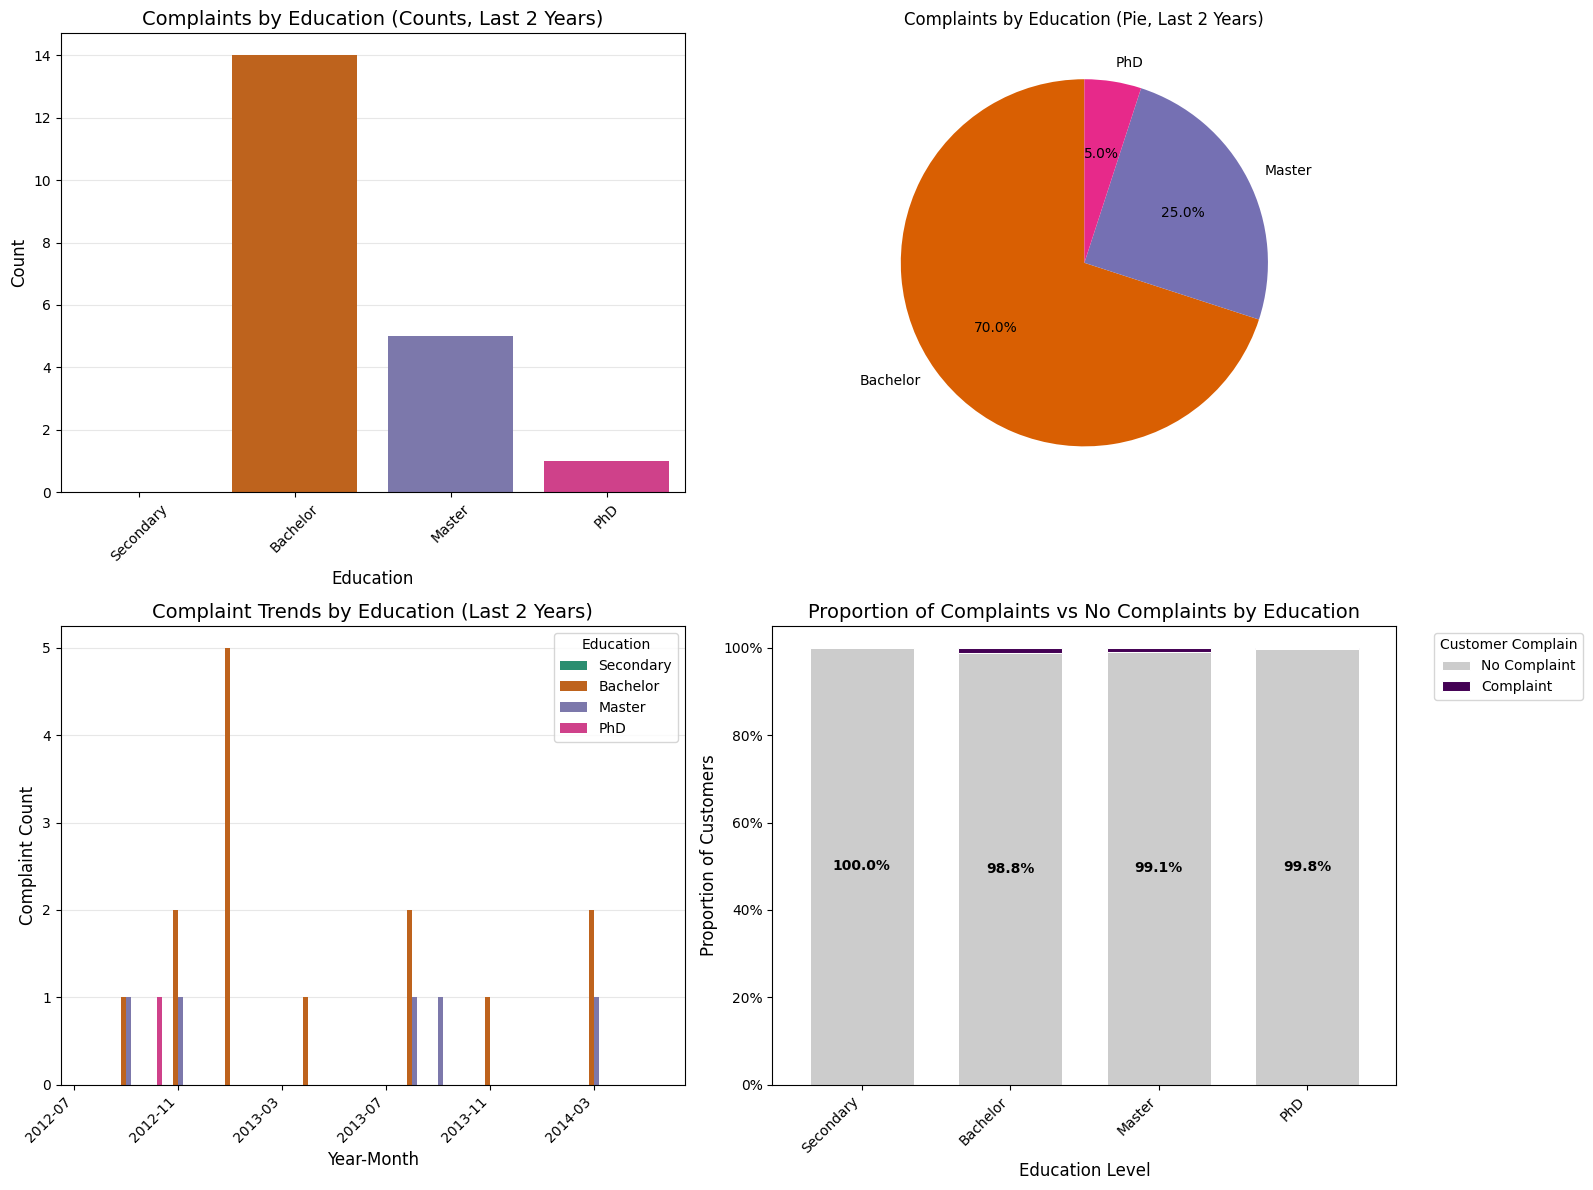

In [102]:
# --- Filter for last 2 years of data ---
latest_date = df["Dt_Customer"].max()
most_recent_date = df["Dt_Customer"].min()
cutoff_date = latest_date - pd.DateOffset(years=2)

complaints_recent = df[df["Dt_Customer"] >= cutoff_date].copy()
complaints_recent["YearMonth"] = complaints_recent["Dt_Customer"].dt.to_period("M")

# --- Map education numbers back to labels ---
edu_map = {1: "Secondary", 2: "Bachelor", 3: "Master", 4: "PhD"}
complaints_recent["Education"] = complaints_recent["Education_Encoded"].map(edu_map)

# --- Define order & palettes ---
edu_order = ["Secondary", "Bachelor", "Master", "PhD"]
# edu_palette = dict(zip(edu_order, sns.color_palette("Set2", len(edu_order))))
# edu_palette = dict(zip(edu_order, sns.color_palette("tab10", len(edu_order))))
edu_palette = dict(zip(edu_order, sns.color_palette("Dark2", len(edu_order))))
complain_palette = {
    0: "#cccccc",
    1: "#440154",
}  # grey = no complaint, purple = complaint

# --- Counts (complaints only) ---
edu_counts = complaints_recent.loc[
    complaints_recent["Complain"] == 1, "Education"
].value_counts()

# --- Complaint vs No Complaint proportions ---
complaint_share = (
    complaints_recent.groupby("Education")["Complain"]
    .value_counts(normalize=True)
    .rename("Proportion")
    .reset_index()
)

stacked_share = complaint_share.pivot(
    index="Education", columns="Complain", values="Proportion"
).fillna(0)

# --- Create subplot grid ---
reset_plot_settings()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Countplot (Complaints only)
ax1.set_axisbelow(True)
ax1.grid(True, axis="y", alpha=0.3, zorder=0)

sns.countplot(
    data=complaints_recent[complaints_recent["Complain"] == 1],
    x="Education",
    order=edu_order,
    palette=edu_palette,
    ax=ax1,
)
ax1.set_title("Complaints by Education (Counts, Last 2 Years)", fontsize=14)
ax1.set_xlabel("Education", fontsize=12)
ax1.set_ylabel("Count", fontsize=12)
ax1.tick_params(axis="x", rotation=45)

# 2. Pie chart (Complaints only)
ax2.pie(
    edu_counts,
    labels=edu_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=[edu_palette[edu] for edu in edu_counts.index],
)
ax2.set_title("Complaints by Education (Pie, Last 2 Years)")

# 3. Trend over time (Complaints only, chronological order)
ax3.set_axisbelow(True)
ax3.grid(True, axis="y", alpha=0.3, zorder=0)

order = sorted(complaints_recent["YearMonth"].unique())
sns.countplot(
    data=complaints_recent[complaints_recent["Complain"] == 1],
    x="YearMonth",
    hue="Education",
    order=order,
    hue_order=edu_order,
    palette=edu_palette,
    ax=ax3,
)
ax3.set_title("Complaint Trends by Education (Last 2 Years)", fontsize=14)
ax3.set_xlabel("Year-Month", fontsize=12)
ax3.set_ylabel("Complaint Count", fontsize=12)

n_ticks = 6  # Desired number of ticks
step = max(1, len(order) // n_ticks)
tick_positions = range(0, len(order), step)
tick_labels = [order[i] for i in tick_positions]

ax3.set_xticks(tick_positions)
ax3.set_xticklabels(tick_labels, rotation=45, ha="right")
ax3.legend(title="Education")

# 4. 100% Stacked Bar (Complaints vs No Complaints)
ax4.set_axisbelow(True)
ax4.grid(True, axis="y", alpha=0.3, zorder=0)

stacked_share.loc[edu_order].plot(
    kind="bar",
    stacked=True,
    ax=ax4,
    color=[complain_palette[c] for c in stacked_share.columns],
    width=0.7,
    edgecolor="white",  # Add white borders between segments
    linewidth=0.75,
)

# Add percentage labels on each segment
for i, education in enumerate(edu_order):
    # Get the values for this education level
    no_complaint_pct = (
        stacked_share.loc[education, 0] * 100
    )  # Assuming 0 = No Complaint
    complaint_pct = stacked_share.loc[education, 1] * 100  # Assuming 1 = Complaint

    # Add label for "No Complaint" segment (bottom part)
    ax4.text(
        i,
        no_complaint_pct / 200,
        f"{no_complaint_pct:.1f}%",
        ha="center",
        va="center",
        fontweight="bold",
        fontsize=10,
    )

# Titles and labels
# ax4.set_title("Customer Complaint Rates by Education Level", fontsize=14)
ax4.set_title("Proportion of Complaints vs No Complaints by Education", fontsize=14)
ax4.set_ylabel("Proportion of Customers", fontsize=12)
ax4.set_xlabel("Education Level", fontsize=12)
ax4.set_xticklabels(edu_order, rotation=45, ha="right")

# Set y-axis to show percentages
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: "{:.0%}".format(y)))

ax4.legend(
    ["No Complaint", "Complaint"],
    title="Customer Complain",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    frameon=True,
    fancybox=True,
)

# ax4.spines['top'].set_visible(False)
# ax4.spines['right'].set_visible(False)
ax4.set_ylim(0, 1.05)  # Add some space at the top

plt.tight_layout()
plt.show()

In [103]:
# Primary Insights:
# - Bachelor's Degree Holders Dominate Complaints
# - Bachelor's represent 70% of all complaints (pie chart) and have the highest absolute count (14 complaints)
# - Complaint Rates Are Consistently Low Across Education Levels
#   - All education groups show 98.8-100% "No Complaint" rates (stacked bar chart)
#   - Secondary education shows 100% satisfaction, while Bachelor's, Master's, and PhD all hover around 98.8-99.1%
#   - The differences between education levels are minimal (less than 2 percentage points)
# - Complaint Activity Is Sporadic
#   - The time trend shows complaints are infrequent and clustered
#   - Most time periods have zero complaints, with occasional spikes
#   - Bachelor's degree holders appear in most complaint periods